# Agency vs Communion: grammatical gender influence

In [1]:
# general
import pandas as pd
import numpy as np
import scipy.stats
import codecs
from matplotlib import pyplot as plt
from numpy import linalg as LA

# bolukbasi's
import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding

# mine
import db_functions as db

### Step 1: Load embeddings

We load all the emdeddings using the same methods and applying the same preprocessing in order to have a common start.

In [2]:
# load Gonen's emdebbings
E_g =  WordEmbedding('../embedding/gonen/it_lemma_to_fem', 'g')

*** Reading data from ../embedding/gonen/it_lemma_to_fem
(160597, 300)
160597 words of dimension 300 : </s>, ,, di, ., ..., title="henrik, pass">, title="nils, title="derrick
160597 words of dimension 300 : </s>, ,, di, ., ..., title="henrik, pass">, title="nils, title="derrick


In [2]:
# load FastText's emdeddings
E_ft =  WordEmbedding('../embedding/fast-text/cc.it.300.reduced.vec', 'ft')

*** Reading data from ../embedding/fast-text/cc.it.300.reduced.vec
(485, 300)
485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica
485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica


### Step 2: working whit FastText's embeddings

### Step 2.1: vector difference

In [3]:
# gender direction
g_diff = E_ft.diff('lui', 'lei')

#### Step 2.2: PCA

In [4]:
# list of pairs to define gender
gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [5]:
# PCA
pca = we.doPCA(gender_pairs, E_ft)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [6]:
print("Singular values:")
print(sv)

Singular values:
[9.5309240e-01 5.3566736e-01 3.7772956e-01 3.4538972e-01 2.9901835e-01
 2.4023318e-01 5.8411594e-08 4.6098762e-08 4.3273410e-08 4.1712632e-08]


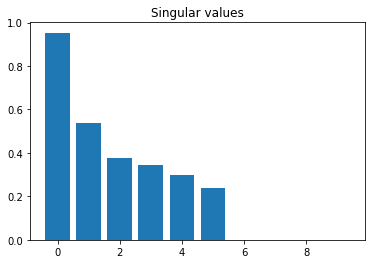

In [7]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [8]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

#### Step 2.3: pseudo-LDA

In [9]:
S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [10]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_ft.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_ft.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_ft.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_ft.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [11]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [12]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

#### Step 2.4: evaluate grammatical gender influence

##### Ungendered words

In [13]:
# words
ag_com_ung = db.read('ag_com_ung_ita.txt', 'ag-com-mf')

In [14]:
# compute projections
# all words ungendered
proj_ag_com_ung_g_diff =  db.prof_proj(E_ft, ag_com_ung, g_diff, 'ag-com-m')
proj_ag_com_ung_g_pca_0 =  db.prof_proj(E_ft, ag_com_ung, g_pca_0, 'ag-com-m')
proj_ag_com_ung_g_pca_01 =  db.prof_proj(E_ft, ag_com_ung, g_pca_01, 'ag-com-m')
proj_ag_com_ung_g_e =  db.prof_proj(E_ft, ag_com_ung, g_e, 'ag-com-m')

In [15]:
# print ag_com_ung results
ag_com_ung_col0 = [] # pandas columns
ag_com_ung_col1 = []
ag_com_ung_col2 = []
ag_com_ung_col3 = []
ag_com_ung_col4 = []
ag_com_ung_col5 = []
ag_com_ung_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_ung_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_ung_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_ung_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_ung_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_ung_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_ung_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_ung_col6.append(proj_ag_com_ung_g_diff[i][3])

ag_com_ung_data = {'Word':ag_com_ung_col0, 
               'Proj g_diff':ag_com_ung_col1,
               'Proj g_pca_0':ag_com_ung_col2, 
               'Proj g_pca_01':ag_com_ung_col3,
               'Proj g_e':ag_com_ung_col4,
               'Agency':ag_com_ung_col5,
               'Communion':ag_com_ung_col6}

ag_com_ung_table = pd.DataFrame(ag_com_ung_data)
ag_com_ung_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency,Communion
0,abile,0.080335,0.102190,0.122643,-0.104315,2.32,0.66
1,altruista,-0.014515,0.007354,0.004393,-0.039926,-1.18,2.50
2,capace,0.059239,0.016343,0.053817,-0.042131,2.45,1.08
3,competente,0.001019,0.001375,-0.003906,-0.059758,2.21,0.61
4,coerente,0.008640,0.028646,0.026779,-0.006384,0.74,1.68
5,dominante,-0.003824,-0.026552,-0.022917,-0.003409,2.76,-1.89
6,amichevole,0.105541,-0.011900,0.071073,0.026077,0.15,2.23
7,disponibile,-0.029067,-0.036633,-0.032159,-0.094269,-0.42,2.76
8,egoista,0.019207,0.068976,0.061825,0.015381,1.53,-2.50
9,indipendente,0.030305,-0.033587,-0.010550,0.002886,2.65,-0.83


##### Gendered words

In [16]:
# words
ag_com_gen = db.read('ag_com_gen_ita.txt', 'ag-com-mf')

In [17]:
# compute projections
# male
proj_ag_com_gen_m_g_diff =  db.prof_proj(E_ft, ag_com_gen, g_diff, 'ag-com-m')
proj_ag_com_gen_m_g_pca_0 =  db.prof_proj(E_ft, ag_com_gen, g_pca_0, 'ag-com-m')
proj_ag_com_gen_m_g_pca_01 =  db.prof_proj(E_ft, ag_com_gen, g_pca_01, 'ag-com-m')
proj_ag_com_gen_m_g_e =  db.prof_proj(E_ft, ag_com_gen, g_e, 'ag-com-m')

# female
proj_ag_com_gen_f_g_diff =  db.prof_proj(E_ft, ag_com_gen, g_diff, 'ag-com-f')
proj_ag_com_gen_f_g_pca_0 =  db.prof_proj(E_ft, ag_com_gen, g_pca_0, 'ag-com-f')
proj_ag_com_gen_f_g_pca_01 =  db.prof_proj(E_ft, ag_com_gen, g_pca_01, 'ag-com-f')
proj_ag_com_gen_f_g_e =  db.prof_proj(E_ft, ag_com_gen, g_e, 'ag-com-f')

In [18]:
# print ag_com_gen_m results
ag_com_gen_m_col0 = [] # pandas columns
ag_com_gen_m_col1 = []
ag_com_gen_m_col2 = []
ag_com_gen_m_col3 = []
ag_com_gen_m_col4 = []
ag_com_gen_m_col5 = []
ag_com_gen_m_col6 = []

for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_gen_m_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_gen_m_col1.append(proj_ag_com_gen_m_g_diff[i][1]) # projection on g_diff
    ag_com_gen_m_col2.append(proj_ag_com_gen_m_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_m_col3.append(proj_ag_com_gen_m_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_m_col4.append(np.real(proj_ag_com_gen_m_g_e[i][1])) # projection on g_e
    ag_com_gen_m_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_gen_m_col6.append(proj_ag_com_gen_m_g_diff[i][3])

ag_com_gen_m_data = {'Word':ag_com_gen_m_col0, 
               'Proj g_diff':ag_com_gen_m_col1,
               'Proj g_pca_0':ag_com_gen_m_col2, 
               'Proj g_pca_01':ag_com_gen_m_col3,
               'Proj g_e':ag_com_gen_m_col4,
               'Agency':ag_com_gen_m_col5,
               'Communion':ag_com_gen_m_col6}

ag_com_gen_m_table = pd.DataFrame(ag_com_gen_m_data)
ag_com_gen_m_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency,Communion
0,attivo,0.133193,0.196107,0.180168,-0.056429,2.35,1.55
1,affettuoso,0.059949,0.173368,0.126707,0.007737,-0.85,1.58
2,ambizioso,0.152494,0.288911,0.251100,-0.012472,2.79,-0.97
3,deciso,0.033273,0.090033,0.046084,-0.009320,2.88,0.43
4,vanitoso,0.105291,0.191813,0.171161,-0.027970,1.29,-1.18
5,confusionario,0.069705,0.196830,0.142547,-0.005169,-1.89,-0.95
6,comunicativo,0.085256,0.186069,0.156890,0.062600,1.50,2.00
7,competitivo,0.072216,0.153743,0.123873,0.033614,2.71,-1.39
8,presuntuoso,0.112785,0.230236,0.198067,-0.019344,1.53,-1.50
9,coscienzioso,0.080623,0.233943,0.178483,0.031092,0.58,1.32


In [19]:
# print ag_com_gen_f results
ag_com_gen_f_col0 = [] # pandas columns
ag_com_gen_f_col1 = []
ag_com_gen_f_col2 = []
ag_com_gen_f_col3 = []
ag_com_gen_f_col4 = []
ag_com_gen_f_col5 = []
ag_com_gen_f_col6 = []

for i in range(len(proj_ag_com_gen_f_g_diff)):
    ag_com_gen_f_col0.append(proj_ag_com_gen_f_g_diff[i][0]) # word
    ag_com_gen_f_col1.append(proj_ag_com_gen_f_g_diff[i][1]) # projection on g_diff
    ag_com_gen_f_col2.append(proj_ag_com_gen_f_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_f_col3.append(proj_ag_com_gen_f_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_f_col4.append(np.real(proj_ag_com_gen_f_g_e[i][1])) # projection on g_e
    ag_com_gen_f_col5.append(proj_ag_com_gen_f_g_diff[i][2])
    ag_com_gen_f_col6.append(proj_ag_com_gen_f_g_diff[i][3])

ag_com_gen_f_data = {'Word':ag_com_gen_f_col0, 
               'Proj g_diff':ag_com_gen_f_col1,
               'Proj g_pca_0':ag_com_gen_f_col2, 
               'Proj g_pca_01':ag_com_gen_f_col3,
               'Proj g_e':ag_com_gen_f_col4,
               'Agency':ag_com_gen_f_col5,
               'Communion':ag_com_gen_f_col6}

ag_com_gen_f_table = pd.DataFrame(ag_com_gen_f_data)
ag_com_gen_f_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency,Communion
0,attiva,-0.064096,-0.168159,-0.144804,-0.067533,2.35,1.55
1,affettuosa,-0.090580,-0.210513,-0.164882,0.021044,-0.85,1.58
2,ambiziosa,-0.092678,-0.189249,-0.159715,-0.005288,2.79,-0.97
3,decisa,-0.067846,-0.143159,-0.145939,-0.013854,2.88,0.43
4,vanitosa,-0.198017,-0.249589,-0.267793,-0.073265,1.29,-1.18
5,confusionaria,-0.055924,-0.151937,-0.139887,-0.011241,-1.89,-0.95
6,comunicativa,-0.036487,-0.132258,-0.091725,0.047612,1.50,2.00
7,competitiva,-0.047236,-0.134371,-0.120322,0.011940,2.71,-1.39
8,presuntuosa,-0.155129,-0.225394,-0.213209,-0.021986,1.53,-1.50
9,coscienziosa,-0.143502,-0.191816,-0.193955,-0.012083,0.58,1.32


In [20]:
# fom (female over male): % of words with female proj > male proj
n_g_diff = 0
n_g_pca_0 = 0
n_g_pca_01 = 0
n_g_e = 0

for i in range(len(ag_com_gen_m_col0)):
    if ag_com_gen_f_col1[i] > ag_com_gen_m_col1[i]:
        n_g_diff += 1
        
    if ag_com_gen_f_col2[i] > ag_com_gen_m_col2[i]:
        n_g_pca_0 += 1

    if ag_com_gen_f_col3[i] > ag_com_gen_m_col3[i]:
        n_g_pca_01 += 1

    if ag_com_gen_f_col4[i] > ag_com_gen_m_col4[i]:
        n_g_e += 1

fom_g_diff = n_g_diff/len(ag_com_gen_m_col0)*100
fom_g_pca_0 = n_g_pca_0/len(ag_com_gen_m_col0)*100
fom_g_pca_01 = n_g_pca_01/len(ag_com_gen_m_col0)*100
fom_g_e = n_g_e/len(ag_com_gen_m_col0)*100

In [21]:
print("fom_g_diff:   %5.2f %%" % (fom_g_diff))
print("fom_g_pca_0:  %5.2f %%" % (fom_g_pca_0))
print("fom_g_pca_01: %5.2f %%" % (fom_g_pca_01))
print("fom_g_e:      %5.2f %%" % (fom_g_e))

fom_g_diff:    2.50 %
fom_g_pca_0:   0.00 %
fom_g_pca_01:  0.00 %
fom_g_e:      40.00 %


##### Ungendered + mean gendered words

In [22]:
# print ag_com_mean results
ag_com_mean_col0 = [] # pandas columns
ag_com_mean_col1 = []
ag_com_mean_col2 = []
ag_com_mean_col3 = []
ag_com_mean_col4 = []
ag_com_mean_col5 = []
ag_com_mean_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_mean_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_mean_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_mean_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_mean_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_ung_g_diff[i][3])
    
for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_mean_col1.append((proj_ag_com_gen_m_g_diff[i][1]+proj_ag_com_gen_f_g_diff[i][1])/2) # projection on g_diff
    ag_com_mean_col2.append((proj_ag_com_gen_m_g_pca_0[i][1]+proj_ag_com_gen_f_g_pca_0[i][1])/2) # projection on g_pca_0
    ag_com_mean_col3.append((proj_ag_com_gen_m_g_pca_01[i][1]+proj_ag_com_gen_f_g_pca_01[i][1])/2) # projection on g_pca_01
    ag_com_mean_col4.append((np.real(proj_ag_com_gen_m_g_e[i][1])+np.real(proj_ag_com_gen_f_g_e[i][1]))/2) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_gen_m_g_diff[i][3])   

ag_com_mean_data = {'Word':ag_com_mean_col0, 
               'Proj g_diff':ag_com_mean_col1,
               'Proj g_pca_0':ag_com_mean_col2, 
               'Proj g_pca_01':ag_com_mean_col3,
               'Proj g_e':ag_com_mean_col4,
               'Agency':ag_com_mean_col5,
               'Communion':ag_com_mean_col6}

ag_com_mean_table = pd.DataFrame(ag_com_mean_data)
ag_com_mean_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency,Communion
0,abile,0.080335,0.102190,0.122643,-0.104315,2.32,0.66
1,altruista,-0.014515,0.007354,0.004393,-0.039926,-1.18,2.50
2,capace,0.059239,0.016343,0.053817,-0.042131,2.45,1.08
3,competente,0.001019,0.001375,-0.003906,-0.059758,2.21,0.61
4,coerente,0.008640,0.028646,0.026779,-0.006384,0.74,1.68
5,dominante,-0.003824,-0.026552,-0.022917,-0.003409,2.76,-1.89
6,amichevole,0.105541,-0.011900,0.071073,0.026077,0.15,2.23
7,disponibile,-0.029067,-0.036633,-0.032159,-0.094269,-0.42,2.76
8,egoista,0.019207,0.068976,0.061825,0.015381,1.53,-2.50
9,indipendente,0.030305,-0.033587,-0.010550,0.002886,2.65,-0.83


In [23]:
# agency gendered subsets
gen_group_0_ag = [] # -3 <= ag < -2
gen_group_1_ag = [] # -2 <= ag < -1
gen_group_2_ag = [] # -1 <= ag < 0
gen_group_3_ag = [] # 0 <= ag < 1
gen_group_4_ag = [] # 1 <= ag < 2
gen_group_5_ag = [] # 2 <= ag <= 3

for i in range(len(ag_com_gen_m_col0)):
    score = ag_com_gen_m_col5[i]
    item = [ag_com_gen_m_col0[i], 
            ag_com_gen_m_col1[i]-ag_com_gen_f_col1[i], 
            ag_com_gen_m_col2[i]-ag_com_gen_f_col2[i],
            ag_com_gen_m_col3[i]-ag_com_gen_f_col3[i],
            ag_com_gen_m_col4[i]-ag_com_gen_f_col4[i],
            score]
    if score < -2:
        gen_group_0_ag.append(item)
    
    elif score >= -2 and score < -1:
        gen_group_1_ag.append(item)
        
    elif score >= -1 and score < 0:
        gen_group_2_ag.append(item)

    elif score >= 0 and score < 1:
        gen_group_3_ag.append(item)

    elif score >= 1 and score < 2:
        gen_group_4_ag.append(item)

    elif score >= 2:
        gen_group_5_ag.append(item)

        
# communion gendered subsets
gen_group_0_com = [] # -3 <= com < -2
gen_group_1_com = [] # -2 <= com < -1
gen_group_2_com = [] # -1 <= com < 0
gen_group_3_com = [] # 0 <= com < 1
gen_group_4_com = [] # 1 <= com < 2
gen_group_5_com = [] # 2 <= com <= 3

for i in range(len(ag_com_gen_m_col0)):
    score = ag_com_gen_m_col6[i]
    item = [ag_com_gen_m_col0[i], 
            ag_com_gen_m_col1[i]-ag_com_gen_f_col1[i], 
            ag_com_gen_m_col2[i]-ag_com_gen_f_col2[i],
            ag_com_gen_m_col3[i]-ag_com_gen_f_col3[i],
            ag_com_gen_m_col4[i]-ag_com_gen_f_col4[i],
            score]
    if score < -2:
        gen_group_0_com.append(item)
    
    elif score >= -2 and score < -1:
        gen_group_1_com.append(item)
        
    elif score >= -1 and score < 0:
        gen_group_2_com.append(item)

    elif score >= 0 and score < 1:
        gen_group_3_com.append(item)

    elif score >= 1 and score < 2:
        gen_group_4_com.append(item)

    elif score >= 2:
        gen_group_5_com.append(item)

In [24]:
def compute_avg(group):
    avg_g_diff = 0
    avg_g_pca_0 = 0
    avg_g_pca_01 = 0
    avg_g_e = 0
    for item in group:
        avg_g_diff = avg_g_diff + item[1]/len(group)
        avg_g_pca_0 = avg_g_pca_0 + item[2]/len(group)
        avg_g_pca_01 = avg_g_pca_01 + item[3]/len(group)
        avg_g_e = avg_g_e + item[4]/len(group)
        
    return [avg_g_diff, avg_g_pca_0, avg_g_pca_01, avg_g_e]

In [25]:
# agency subgroup average differences of gendered projections
group_0_ag_ext = compute_avg(gen_group_0_ag)
group_1_ag_ext = compute_avg(gen_group_1_ag)
group_2_ag_ext = compute_avg(gen_group_2_ag)
group_3_ag_ext = compute_avg(gen_group_3_ag)
group_4_ag_ext = compute_avg(gen_group_4_ag)
group_5_ag_ext = compute_avg(gen_group_5_ag)

# communion subgroup average differences of gendered projections
group_0_com_ext = compute_avg(gen_group_0_com)
group_1_com_ext = compute_avg(gen_group_1_com)
group_2_com_ext = compute_avg(gen_group_2_com)
group_3_com_ext = compute_avg(gen_group_3_com)
group_4_com_ext = compute_avg(gen_group_4_com)
group_5_com_ext = compute_avg(gen_group_5_com)

In [26]:
# agency mean (ung + mean gendered) subsets
mean_group_0_ag = [] # -3 <= ag < -2
mean_group_1_ag = [] # -2 <= ag < -1
mean_group_2_ag = [] # -1 <= ag < 0
mean_group_3_ag = [] # 0 <= ag < 1
mean_group_4_ag = [] # 1 <= ag < 2
mean_group_5_ag = [] # 2 <= ag <= 3

for i in range(len(ag_com_mean_col0)):
    score = ag_com_mean_col5[i]
    item = [ag_com_mean_col0[i], 
            ag_com_mean_col1[i], 
            ag_com_mean_col2[i],
            ag_com_mean_col3[i],
            ag_com_mean_col4[i],
            score]
    if score < -2:
        mean_group_0_ag.append(item)
    
    elif score >= -2 and score < -1:
        mean_group_1_ag.append(item)
        
    elif score >= -1 and score < 0:
        mean_group_2_ag.append(item)

    elif score >= 0 and score < 1:
        mean_group_3_ag.append(item)

    elif score >= 1 and score < 2:
        mean_group_4_ag.append(item)

    elif score >= 2:
        mean_group_5_ag.append(item)

        
# communion mean (ung + mean gendered) subsets
mean_group_0_com = [] # -3 <= com < -2
mean_group_1_com = [] # -2 <= com < -1
mean_group_2_com = [] # -1 <= com < 0
mean_group_3_com = [] # 0 <= com < 1
mean_group_4_com = [] # 1 <= com < 2
mean_group_5_com = [] # 2 <= com <= 3

for i in range(len(ag_com_mean_col0)):
    score = ag_com_mean_col6[i]
    item = [ag_com_mean_col0[i], 
            ag_com_mean_col1[i], 
            ag_com_mean_col2[i],
            ag_com_mean_col3[i],
            ag_com_mean_col4[i],
            score]
    if score < -2:
        mean_group_0_com.append(item)
    
    elif score >= -2 and score < -1:
        mean_group_1_com.append(item)
        
    elif score >= -1 and score < 0:
        mean_group_2_com.append(item)

    elif score >= 0 and score < 1:
        mean_group_3_com.append(item)

    elif score >= 1 and score < 2:
        mean_group_4_com.append(item)

    elif score >= 2:
        mean_group_5_com.append(item)

In [27]:
# agency subgroup average projection
group_0_ag_avg_proj = compute_avg(mean_group_0_ag)
group_1_ag_avg_proj = compute_avg(mean_group_1_ag)
group_2_ag_avg_proj = compute_avg(mean_group_2_ag)
group_3_ag_avg_proj = compute_avg(mean_group_3_ag)
group_4_ag_avg_proj = compute_avg(mean_group_4_ag)
group_5_ag_avg_proj = compute_avg(mean_group_5_ag)

# communion subgroup average projection
group_0_com_avg_proj = compute_avg(mean_group_0_com)
group_1_com_avg_proj = compute_avg(mean_group_1_com)
group_2_com_avg_proj = compute_avg(mean_group_2_com)
group_3_com_avg_proj = compute_avg(mean_group_3_com)
group_4_com_avg_proj = compute_avg(mean_group_4_com)
group_5_com_avg_proj = compute_avg(mean_group_5_com)

In [28]:
# avg difference between male and female projection
avg_diff_g_diff = np.mean(np.absolute(np.array(ag_com_gen_m_col1) - np.array(ag_com_gen_f_col1)))
avg_diff_g_pca_0 = np.mean(np.absolute(np.array(ag_com_gen_m_col2) - np.array(ag_com_gen_f_col2)))
avg_diff_g_pca_01 = np.mean(np.absolute(np.array(ag_com_gen_m_col3) - np.array(ag_com_gen_f_col3)))
avg_diff_g_e = np.mean(np.absolute(np.array(ag_com_gen_m_col4) - np.array(ag_com_gen_f_col4)))

In [29]:
print("avg_diff_g_diff:   %9.8f" % (avg_diff_g_diff))
print("avg_diff_g_pca_0:  %9.8f" % (avg_diff_g_pca_0))
print("avg_diff_g_pca_01: %9.8f" % (avg_diff_g_pca_01))
print("avg_diff_g_e:      %9.8f" % (avg_diff_g_e))

avg_diff_g_diff:   0.18379173
avg_diff_g_pca_0:  0.35226750
avg_diff_g_pca_01: 0.30395931
avg_diff_g_e:      0.01577382


In [30]:
# agency average projections
ag_avg_proj_g_diff = [group_0_ag_avg_proj[0],
                      group_1_ag_avg_proj[0],
                      group_2_ag_avg_proj[0],
                      group_3_ag_avg_proj[0],
                      group_4_ag_avg_proj[0],
                      group_5_ag_avg_proj[0]]

ag_avg_proj_g_pca_0 = [group_0_ag_avg_proj[1],
                      group_1_ag_avg_proj[1],
                      group_2_ag_avg_proj[1],
                      group_3_ag_avg_proj[1],
                      group_4_ag_avg_proj[1],
                      group_5_ag_avg_proj[1]]

ag_avg_proj_g_pca_01 = [group_0_ag_avg_proj[2],
                      group_1_ag_avg_proj[2],
                      group_2_ag_avg_proj[2],
                      group_3_ag_avg_proj[2],
                      group_4_ag_avg_proj[2],
                      group_5_ag_avg_proj[2]]

ag_avg_proj_g_e = [group_0_ag_avg_proj[3],
                      group_1_ag_avg_proj[3],
                      group_2_ag_avg_proj[3],
                      group_3_ag_avg_proj[3],
                      group_4_ag_avg_proj[3],
                      group_5_ag_avg_proj[3]]

# communion average projections
com_avg_proj_g_diff = [group_0_com_avg_proj[0],
                      group_1_com_avg_proj[0],
                      group_2_com_avg_proj[0],
                      group_3_com_avg_proj[0],
                      group_4_com_avg_proj[0],
                      group_5_com_avg_proj[0]]

com_avg_proj_g_pca_0 = [group_0_com_avg_proj[1],
                      group_1_com_avg_proj[1],
                      group_2_com_avg_proj[1],
                      group_3_com_avg_proj[1],
                      group_4_com_avg_proj[1],
                      group_5_com_avg_proj[1]]

com_avg_proj_g_pca_01 = [group_0_com_avg_proj[2],
                      group_1_com_avg_proj[2],
                      group_2_com_avg_proj[2],
                      group_3_com_avg_proj[2],
                      group_4_com_avg_proj[2],
                      group_5_com_avg_proj[2]]

com_avg_proj_g_e = [group_0_com_avg_proj[3],
                      group_1_com_avg_proj[3],
                      group_2_com_avg_proj[3],
                      group_3_com_avg_proj[3],
                      group_4_com_avg_proj[3],
                      group_5_com_avg_proj[3]]

In [31]:
# agency extensions
ag_ext_g_diff = [group_0_ag_ext[0],
                 group_1_ag_ext[0],
                 group_2_ag_ext[0],
                 group_3_ag_ext[0],
                 group_4_ag_ext[0],
                 group_5_ag_ext[0]]

ag_ext_g_pca_0 = [group_0_ag_ext[1],
                 group_1_ag_ext[1],
                 group_2_ag_ext[1],
                 group_3_ag_ext[1],
                 group_4_ag_ext[1],
                 group_5_ag_ext[1]]

ag_ext_g_pca_01 = [group_0_ag_ext[2],
                 group_1_ag_ext[2],
                 group_2_ag_ext[2],
                 group_3_ag_ext[2],
                 group_4_ag_ext[2],
                 group_5_ag_ext[2]]

ag_ext_g_e = [group_0_ag_ext[3],
                 group_1_ag_ext[3],
                 group_2_ag_ext[3],
                 group_3_ag_ext[3],
                 group_4_ag_ext[3],
                 group_5_ag_ext[3]]

# communion extensions
com_ext_g_diff = [group_0_com_ext[0],
                 group_1_com_ext[0],
                 group_2_com_ext[0],
                 group_3_com_ext[0],
                 group_4_com_ext[0],
                 group_5_com_ext[0]]

com_ext_g_pca_0 = [group_0_com_ext[1],
                 group_1_com_ext[1],
                 group_2_com_ext[1],
                 group_3_com_ext[1],
                 group_4_com_ext[1],
                 group_5_com_ext[1]]

com_ext_g_pca_01 = [group_0_com_ext[2],
                 group_1_com_ext[2],
                 group_2_com_ext[2],
                 group_3_com_ext[2],
                 group_4_com_ext[2],
                 group_5_com_ext[2]]

com_ext_g_e = [group_0_com_ext[3],
                 group_1_com_ext[3],
                 group_2_com_ext[3],
                 group_3_com_ext[3],
                 group_4_com_ext[3],
                 group_5_com_ext[3]]

0.05083153597506988


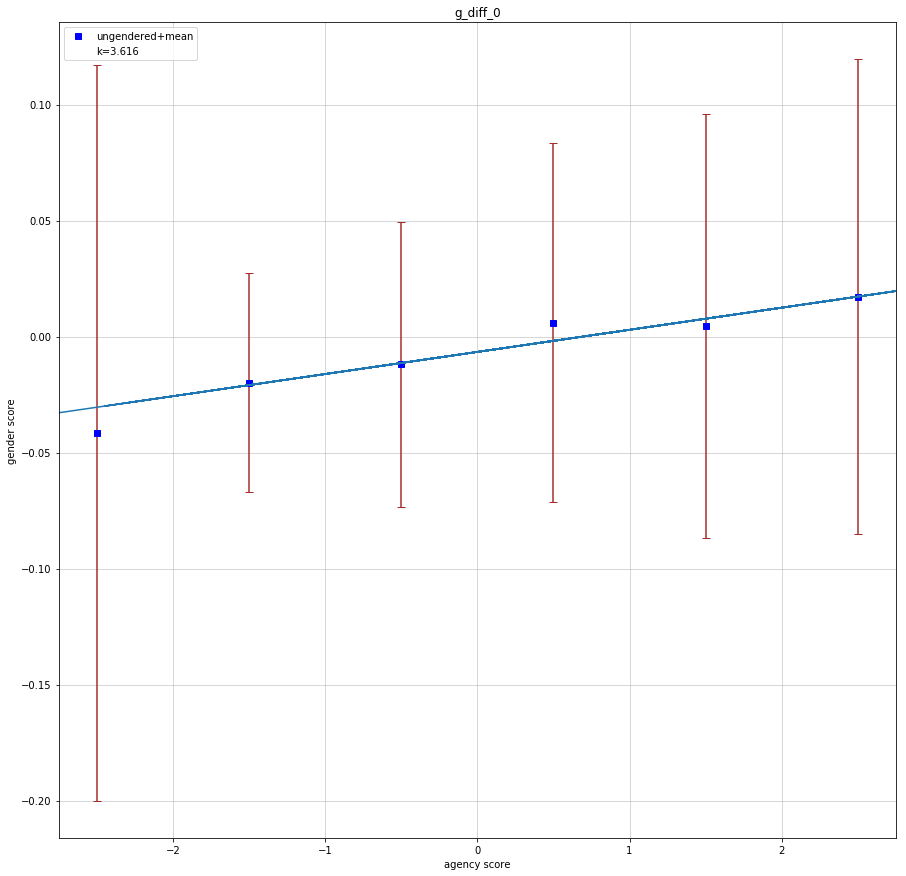

In [32]:
# agency plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(np.arange(-2.5,3,1), ag_avg_proj_g_diff, linewidth=0, marker='s', color='blue', label='ungendered+mean')

ymins = []
ymaxs = []
for i in range(len(ag_ext_g_diff)):
    if ag_ext_g_diff[i] < 0:
        print("warning: negative extension value")
    ymins.append(ag_avg_proj_g_diff[i]-ag_ext_g_diff[i]/2)
    ymaxs.append(ag_avg_proj_g_diff[i]+ag_ext_g_diff[i]/2)

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

#ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
xlims = plt.xlim()
x = [i for i in ag_com_mean_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)

score_max = np.max(ag_com_mean_col5)
score_min = np.min(ag_com_mean_col5)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_ag_g_diff = avg_diff_g_diff/line_delta
plt.plot([], [], ' ', label=f'k={k_ag_g_diff:1.3f}')

ax.set_xlabel('agency score')
ax.set_ylabel('gender score')
ax.set_title("g_diff_0")
ax.legend()

plt.show()
fig.savefig('k-plot/ag/ft_g_diff.pdf', bbox_inches='tight', format='pdf')

0.021447277864090543


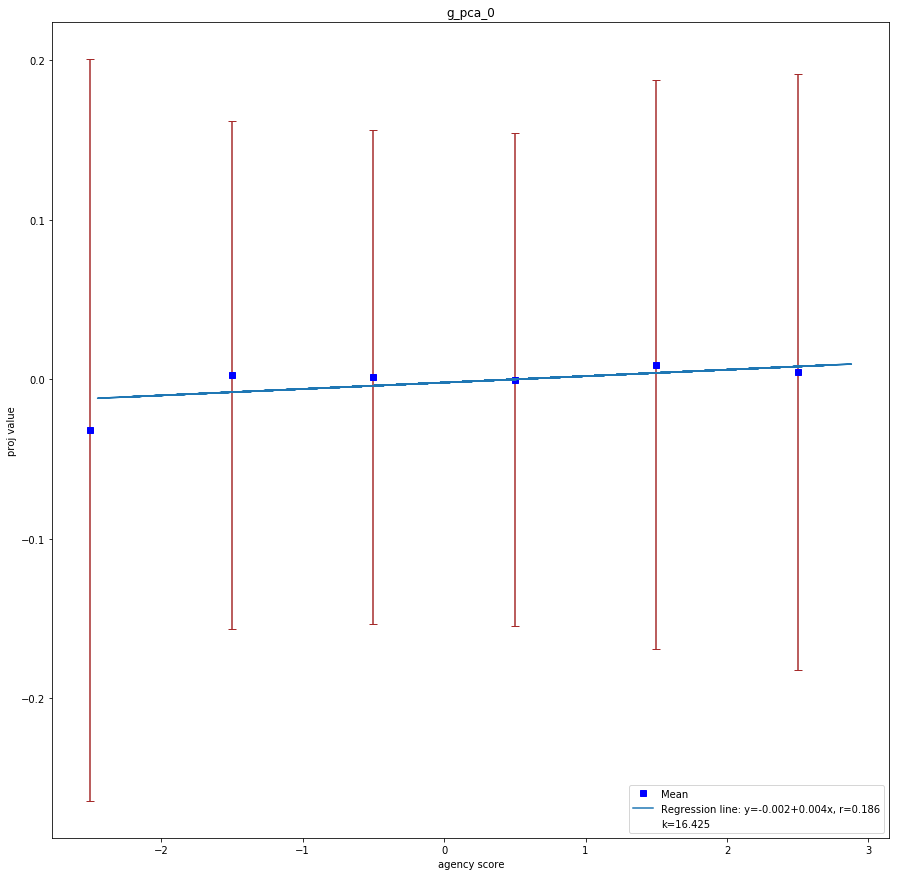

In [33]:
# agency plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col2)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), ag_avg_proj_g_pca_0, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(ag_ext_g_pca_0)):
    if ag_ext_g_pca_0[i] < 0:
        print("warning: negative extension value")
    ymins.append(ag_avg_proj_g_pca_0[i]-ag_ext_g_pca_0[i]/2)
    ymaxs.append(ag_avg_proj_g_pca_0[i]+ag_ext_g_pca_0[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)

score_max = np.max(ag_com_mean_col5)
score_min = np.min(ag_com_mean_col5)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_ag_g_pca_0 = avg_diff_g_pca_0/line_delta
plt.plot([], [], ' ', label=f'k={k_ag_g_pca_0:1.3f}')

ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/ag/ft_g_pca_0')

0.03714648830852298


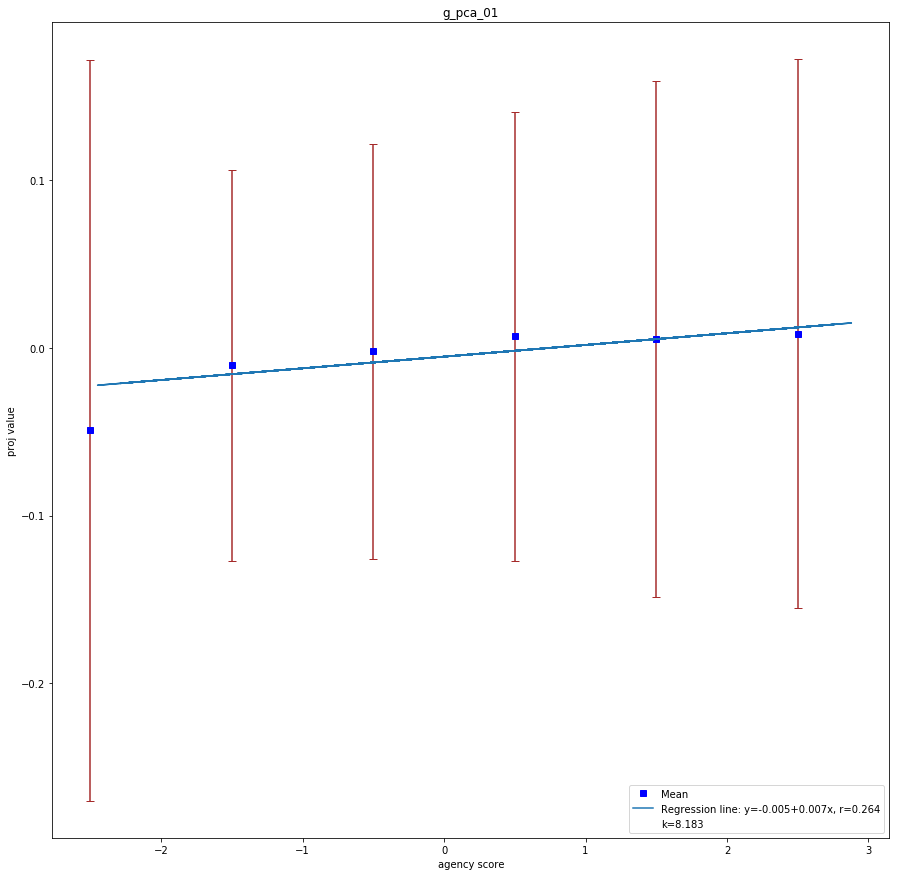

In [34]:
# agency plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col3)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), ag_avg_proj_g_pca_01, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(ag_ext_g_pca_01)):
    if ag_ext_g_pca_01[i] < 0:
        print("warning: negative extension value")
    ymins.append(ag_avg_proj_g_pca_01[i]-ag_ext_g_pca_01[i]/2)
    ymaxs.append(ag_avg_proj_g_pca_01[i]+ag_ext_g_pca_01[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)

score_max = np.max(ag_com_mean_col5)
score_min = np.min(ag_com_mean_col5)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_ag_g_pca_01 = avg_diff_g_pca_01/line_delta
plt.plot([], [], ' ', label=f'k={k_ag_g_pca_01:1.3f}')

ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/ag/ft_g_pca_01')

0.0029287621770450536


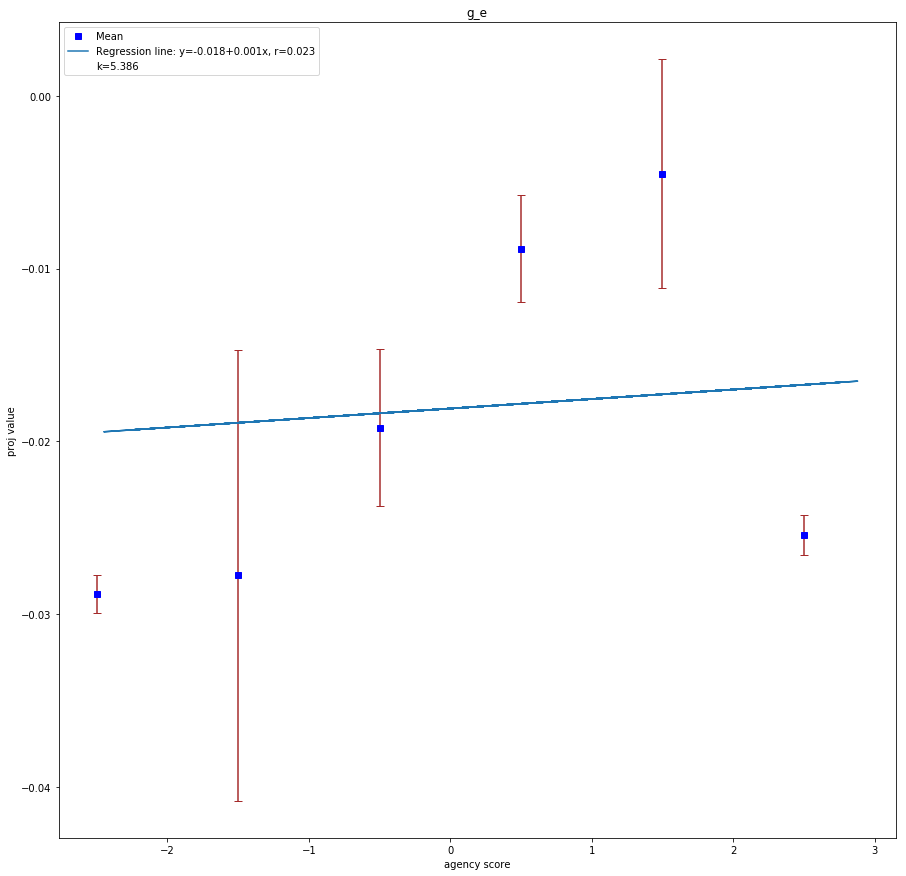

In [35]:
# agency plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col4)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), ag_avg_proj_g_e, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(ag_ext_g_e)):
    if ag_ext_g_e[i] < 0:
        print("warning: negative extension value")
    ymins.append(ag_avg_proj_g_e[i]-ag_ext_g_e[i]/2)
    ymaxs.append(ag_avg_proj_g_e[i]+ag_ext_g_e[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)

score_max = np.max(ag_com_mean_col5)
score_min = np.min(ag_com_mean_col5)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_ag_g_e = avg_diff_g_e/line_delta
plt.plot([], [], ' ', label=f'k={k_ag_g_e:1.3f}')

ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/ag/ft_g_e')

-0.00178904110953115


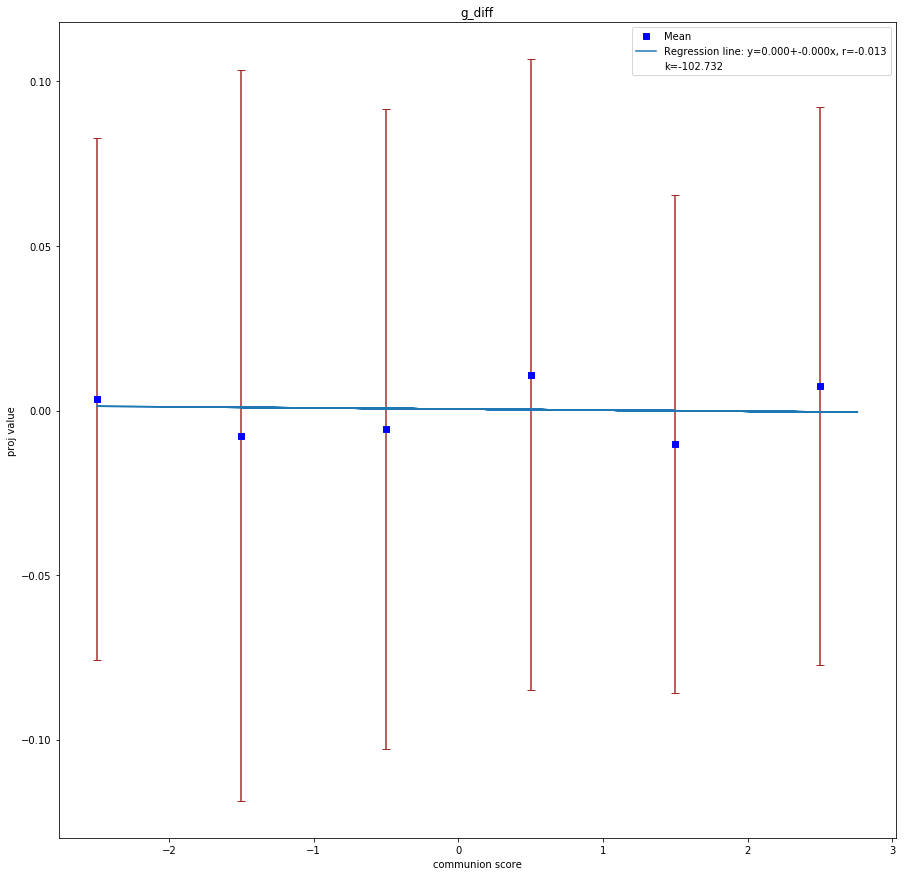

In [36]:
# communion plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col1)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), com_avg_proj_g_diff, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(com_ext_g_diff)):
    if com_ext_g_diff[i] < 0:
        print("warning: negative extension value")
    ymins.append(com_avg_proj_g_diff[i]-com_ext_g_diff[i]/2)
    ymaxs.append(com_avg_proj_g_diff[i]+com_ext_g_diff[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)

score_max = np.max(ag_com_mean_col6)
score_min = np.min(ag_com_mean_col6)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_com_g_diff = avg_diff_g_diff/line_delta
plt.plot([], [], ' ', label=f'k={k_com_g_diff:1.3f}')

ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/com/ft_g_diff')

0.013895580632214528


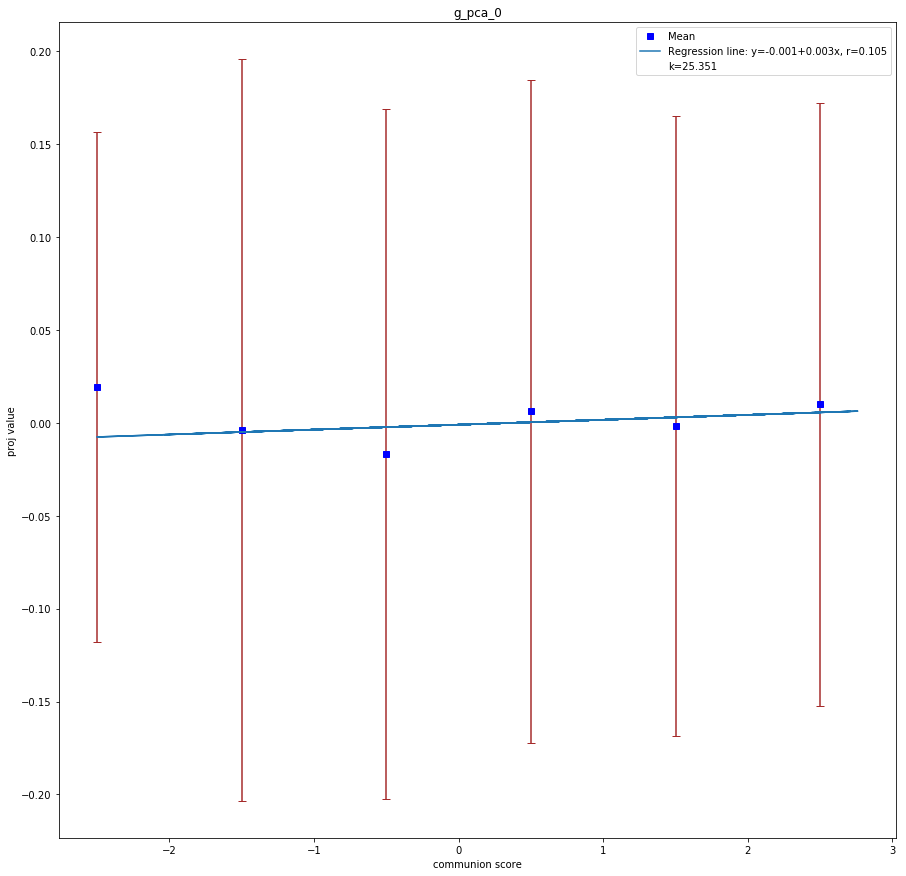

In [37]:
# communion plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col2)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), com_avg_proj_g_pca_0, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(com_ext_g_pca_0)):
    if com_ext_g_pca_0[i] < 0:
        print("warning: negative extension value")
    ymins.append(com_avg_proj_g_pca_0[i]-com_ext_g_pca_0[i]/2)
    ymaxs.append(com_avg_proj_g_pca_0[i]+com_ext_g_pca_0[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)

score_max = np.max(ag_com_mean_col6)
score_min = np.min(ag_com_mean_col6)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_com_g_pca_0 = avg_diff_g_pca_0/line_delta
plt.plot([], [], ' ', label=f'k={k_com_g_pca_0:1.3f}')

ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/com/ft_g_pca_0')

0.02213552318506643


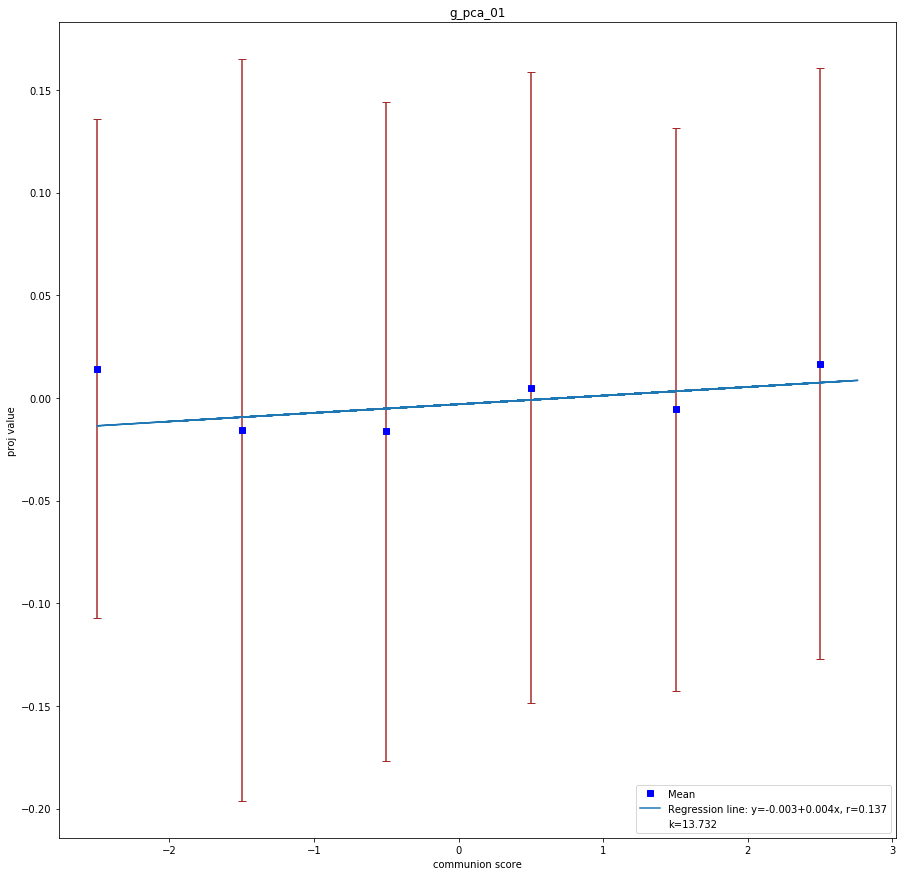

In [38]:
# communion plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col3)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), com_avg_proj_g_pca_01, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(com_ext_g_pca_01)):
    if com_ext_g_pca_01[i] < 0:
        print("warning: negative extension value")
    ymins.append(com_avg_proj_g_pca_01[i]-com_ext_g_pca_01[i]/2)
    ymaxs.append(com_avg_proj_g_pca_01[i]+com_ext_g_pca_01[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)

score_max = np.max(ag_com_mean_col6)
score_min = np.min(ag_com_mean_col6)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_com_g_pca_01 = avg_diff_g_pca_01/line_delta
plt.plot([], [], ' ', label=f'k={k_com_g_pca_01:1.3f}')

ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/com/ft_g_pca_01')

0.0026486917039947183


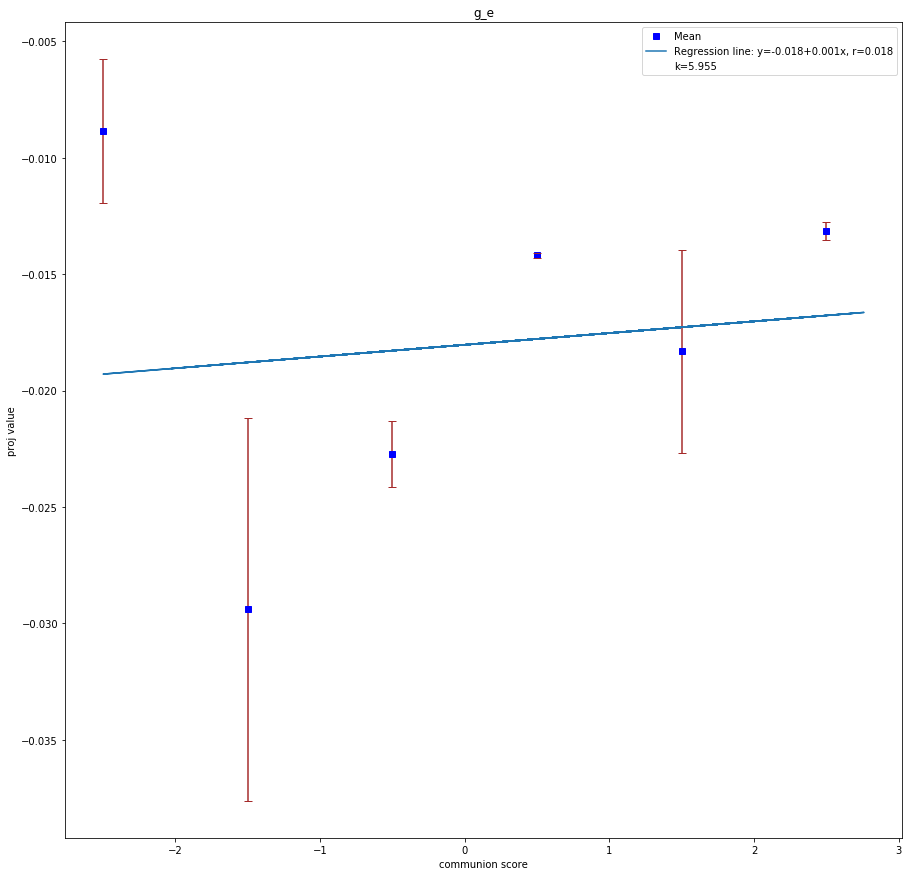

In [39]:
# communion plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col4)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), com_avg_proj_g_e, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(com_ext_g_e)):
    if com_ext_g_e[i] < 0:
        print("warning: negative extension value")
    ymins.append(com_avg_proj_g_e[i]-com_ext_g_e[i]/2)
    ymaxs.append(com_avg_proj_g_e[i]+com_ext_g_e[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)

score_max = np.max(ag_com_mean_col6)
score_min = np.min(ag_com_mean_col6)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_com_g_e = avg_diff_g_e/line_delta
plt.plot([], [], ' ', label=f'k={k_com_g_e:1.3f}')

ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/com/ft_g_e')

In [40]:
# print k
print('k_ag_g_diff:    %6.3lf' % (k_ag_g_diff))
print('k_ag_g_pca_0:   %6.3f' % (k_ag_g_pca_0))
print('k_ag_g_pca_01:  %6.3f' % (k_ag_g_pca_01))
print('k_ag_g_e:       %6.3f' % (k_ag_g_e))
print()
print('k_com_g_diff:   %6.3f' % (k_com_g_diff))
print('k_com_g_pca_0:  %6.3f' % (k_com_g_pca_0))
print('k_com_g_pca_01: %6.3f' % (k_com_g_pca_01))
print('k_com_g_e:      %6.3f' % (k_com_g_e))

k_ag_g_diff:     3.616
k_ag_g_pca_0:   16.425
k_ag_g_pca_01:   8.183
k_ag_g_e:        5.386

k_com_g_diff:   -102.732
k_com_g_pca_0:  25.351
k_com_g_pca_01: 13.732
k_com_g_e:       5.955


#### Step 2.6: subtracting grammatical gender to the emdeddings

In [33]:
from debiaswe.debias import debias

In [34]:
debias(E_ft, [], G_word, [])

485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica
set()
485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica


In [35]:
# gender direction
g_diff = E_ft.diff('lui', 'lei')

In [36]:
# list of pairs to define gender
gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [37]:
# PCA
pca = we.doPCA(gender_pairs, E_ft)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [38]:
print("Singular values:")
print(sv)

Singular values:
[6.9684738e-01 5.0248235e-01 3.8360339e-01 3.4403831e-01 3.0402446e-01
 2.4636908e-01 6.0329249e-08 4.8515240e-08 4.6014925e-08 3.9377852e-08]


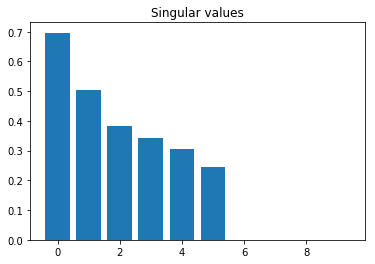

In [39]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [40]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

In [41]:
S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [42]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_ft.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_ft.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_ft.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_ft.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [43]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [44]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

##### Ungendered words

In [45]:
# words
ag_com_ung = db.read('ag_com_ung_ita.txt', 'ag-com-mf')

In [46]:
# compute projections
# all words ungendered
proj_ag_com_ung_g_diff =  db.prof_proj(E_ft, ag_com_ung, g_diff, 'ag-com-m')
proj_ag_com_ung_g_pca_0 =  db.prof_proj(E_ft, ag_com_ung, g_pca_0, 'ag-com-m')
proj_ag_com_ung_g_pca_01 =  db.prof_proj(E_ft, ag_com_ung, g_pca_01, 'ag-com-m')
proj_ag_com_ung_g_e =  db.prof_proj(E_ft, ag_com_ung, g_e, 'ag-com-m')

In [47]:
# print ag_com_ung results
ag_com_ung_col0 = [] # pandas columns
ag_com_ung_col1 = []
ag_com_ung_col2 = []
ag_com_ung_col3 = []
ag_com_ung_col4 = []
ag_com_ung_col5 = []
ag_com_ung_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_ung_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_ung_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_ung_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_ung_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_ung_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_ung_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_ung_col6.append(proj_ag_com_ung_g_diff[i][3])

ag_com_ung_data = {'Word':ag_com_ung_col0, 
               'Proj g_diff':ag_com_ung_col1,
               'Proj g_pca_0':ag_com_ung_col2, 
               'Proj g_pca_01':ag_com_ung_col3,
               'Proj g_e':ag_com_ung_col4,
               'Agency':ag_com_ung_col5,
               'Communion':ag_com_ung_col6}

ag_com_ung_table = pd.DataFrame(ag_com_ung_data)
ag_com_ung_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency,Communion
0,abile,0.067950,0.095182,0.054223,-0.026474,2.32,0.66
1,altruista,-0.009973,0.014702,0.020507,0.009811,-1.18,2.50
2,capace,0.060599,0.029318,-0.024584,-0.026633,2.45,1.08
3,competente,0.003687,-0.000513,0.007158,-0.049972,2.21,0.61
4,coerente,0.007508,0.024642,0.021850,-0.008620,0.74,1.68
5,dominante,0.011981,0.008073,0.015497,0.084365,2.76,-1.89
6,amichevole,0.126366,0.082296,-0.011115,0.083360,0.15,2.23
7,disponibile,-0.034073,-0.068511,-0.080057,0.000437,-0.42,2.76
8,egoista,0.012170,0.052224,0.047923,-0.057813,1.53,-2.50
9,indipendente,0.043086,-0.003854,-0.025846,0.077823,2.65,-0.83


##### Gendered words

In [48]:
# words
ag_com_gen = db.read('ag_com_gen_ita.txt', 'ag-com-mf')

In [49]:
# compute projections
# male
proj_ag_com_gen_m_g_diff =  db.prof_proj(E_ft, ag_com_gen, g_diff, 'ag-com-m')
proj_ag_com_gen_m_g_pca_0 =  db.prof_proj(E_ft, ag_com_gen, g_pca_0, 'ag-com-m')
proj_ag_com_gen_m_g_pca_01 =  db.prof_proj(E_ft, ag_com_gen, g_pca_01, 'ag-com-m')
proj_ag_com_gen_m_g_e =  db.prof_proj(E_ft, ag_com_gen, g_e, 'ag-com-m')

# female
proj_ag_com_gen_f_g_diff =  db.prof_proj(E_ft, ag_com_gen, g_diff, 'ag-com-f')
proj_ag_com_gen_f_g_pca_0 =  db.prof_proj(E_ft, ag_com_gen, g_pca_0, 'ag-com-f')
proj_ag_com_gen_f_g_pca_01 =  db.prof_proj(E_ft, ag_com_gen, g_pca_01, 'ag-com-f')
proj_ag_com_gen_f_g_e =  db.prof_proj(E_ft, ag_com_gen, g_e, 'ag-com-f')

In [50]:
# print ag_com_gen_m results
ag_com_gen_m_col0 = [] # pandas columns
ag_com_gen_m_col1 = []
ag_com_gen_m_col2 = []
ag_com_gen_m_col3 = []
ag_com_gen_m_col4 = []
ag_com_gen_m_col5 = []
ag_com_gen_m_col6 = []

for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_gen_m_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_gen_m_col1.append(proj_ag_com_gen_m_g_diff[i][1]) # projection on g_diff
    ag_com_gen_m_col2.append(proj_ag_com_gen_m_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_m_col3.append(proj_ag_com_gen_m_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_m_col4.append(np.real(proj_ag_com_gen_m_g_e[i][1])) # projection on g_e
    ag_com_gen_m_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_gen_m_col6.append(proj_ag_com_gen_m_g_diff[i][3])

ag_com_gen_m_data = {'Word':ag_com_gen_m_col0, 
               'Proj g_diff':ag_com_gen_m_col1,
               'Proj g_pca_0':ag_com_gen_m_col2, 
               'Proj g_pca_01':ag_com_gen_m_col3,
               'Proj g_e':ag_com_gen_m_col4,
               'Agency':ag_com_gen_m_col5,
               'Communion':ag_com_gen_m_col6}

ag_com_gen_m_table = pd.DataFrame(ag_com_gen_m_data)
ag_com_gen_m_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency,Communion
0,attivo,0.071174,0.019152,-0.033121,0.044490,2.35,1.55
1,affettuoso,0.006202,0.015842,0.021619,-0.008400,-0.85,1.58
2,ambizioso,0.093759,0.149160,0.131320,-0.047719,2.79,-0.97
3,deciso,0.003020,-0.019046,0.003876,0.013403,2.88,0.43
4,vanitoso,0.043833,0.022666,-0.015089,-0.113481,1.29,-1.18
5,confusionario,-0.003857,-0.021389,-0.026329,0.036327,-1.89,-0.95
6,comunicativo,0.015293,-0.015848,-0.054754,0.009934,1.50,2.00
7,competitivo,0.012577,-0.026535,-0.053721,0.111068,2.71,-1.39
8,presuntuoso,0.051027,0.065290,0.038252,-0.069500,1.53,-1.50
9,coscienzioso,0.020052,0.066722,0.072015,0.014911,0.58,1.32


In [51]:
# print ag_com_gen_f results
ag_com_gen_f_col0 = [] # pandas columns
ag_com_gen_f_col1 = []
ag_com_gen_f_col2 = []
ag_com_gen_f_col3 = []
ag_com_gen_f_col4 = []
ag_com_gen_f_col5 = []
ag_com_gen_f_col6 = []

for i in range(len(proj_ag_com_gen_f_g_diff)):
    ag_com_gen_f_col0.append(proj_ag_com_gen_f_g_diff[i][0]) # word
    ag_com_gen_f_col1.append(proj_ag_com_gen_f_g_diff[i][1]) # projection on g_diff
    ag_com_gen_f_col2.append(proj_ag_com_gen_f_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_f_col3.append(proj_ag_com_gen_f_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_f_col4.append(np.real(proj_ag_com_gen_f_g_e[i][1])) # projection on g_e
    ag_com_gen_f_col5.append(proj_ag_com_gen_f_g_diff[i][2])
    ag_com_gen_f_col6.append(proj_ag_com_gen_f_g_diff[i][3])

ag_com_gen_f_data = {'Word':ag_com_gen_f_col0, 
               'Proj g_diff':ag_com_gen_f_col1,
               'Proj g_pca_0':ag_com_gen_f_col2, 
               'Proj g_pca_01':ag_com_gen_f_col3,
               'Proj g_e':ag_com_gen_f_col4,
               'Agency':ag_com_gen_f_col5,
               'Communion':ag_com_gen_f_col6}

ag_com_gen_f_table = pd.DataFrame(ag_com_gen_f_data)
ag_com_gen_f_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency,Communion
0,attiva,0.002016,0.003485,0.039964,0.057910,2.35,1.55
1,affettuosa,-0.008045,0.019432,0.044750,-0.028446,-0.85,1.58
2,ambiziosa,-0.011621,0.037397,0.085467,-0.008890,2.79,-0.97
3,decisa,-0.002498,0.023271,0.096952,0.005985,2.88,0.43
4,vanitosa,-0.144254,-0.147390,-0.055853,-0.057083,1.29,-1.18
5,confusionaria,0.005371,0.010171,0.062122,0.036267,-1.89,-0.95
6,comunicativa,0.039279,0.093837,0.114020,-0.030641,1.50,2.00
7,competitiva,0.018495,0.041719,0.088326,0.066634,2.71,-1.39
8,presuntuosa,-0.083805,-0.040582,0.025473,0.001745,1.53,-1.50
9,coscienziosa,-0.078029,-0.028326,0.047376,0.107371,0.58,1.32


In [52]:
# fom (female over male): % of words with female proj > male proj
n_g_diff = 0
n_g_pca_0 = 0
n_g_pca_01 = 0
n_g_e = 0

for i in range(len(ag_com_gen_m_col0)):
    if ag_com_gen_f_col1[i] > ag_com_gen_m_col1[i]:
        n_g_diff += 1
        
    if ag_com_gen_f_col2[i] > ag_com_gen_m_col2[i]:
        n_g_pca_0 += 1

    if ag_com_gen_f_col3[i] > ag_com_gen_m_col3[i]:
        n_g_pca_01 += 1

    if ag_com_gen_f_col4[i] > ag_com_gen_m_col4[i]:
        n_g_e += 1

fom_g_diff = n_g_diff/len(ag_com_gen_m_col0)*100
fom_g_pca_0 = n_g_pca_0/len(ag_com_gen_m_col0)*100
fom_g_pca_01 = n_g_pca_01/len(ag_com_gen_m_col0)*100
fom_g_e = n_g_e/len(ag_com_gen_m_col0)*100

In [53]:
print("fom_g_diff:   %5.2f %%" % (fom_g_diff))
print("fom_g_pca_0:  %5.2f %%" % (fom_g_pca_0))
print("fom_g_pca_01: %5.2f %%" % (fom_g_pca_01))
print("fom_g_e:      %5.2f %%" % (fom_g_e))

fom_g_diff:   40.00 %
fom_g_pca_0:  52.50 %
fom_g_pca_01: 67.50 %
fom_g_e:      67.50 %


##### Ungendered + mean gendered words

In [54]:
# print ag_com_mean results
ag_com_mean_col0 = [] # pandas columns
ag_com_mean_col1 = []
ag_com_mean_col2 = []
ag_com_mean_col3 = []
ag_com_mean_col4 = []
ag_com_mean_col5 = []
ag_com_mean_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_mean_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_mean_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_mean_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_mean_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_ung_g_diff[i][3])
    
for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_mean_col1.append((proj_ag_com_gen_m_g_diff[i][1]+proj_ag_com_gen_f_g_diff[i][1])/2) # projection on g_diff
    ag_com_mean_col2.append((proj_ag_com_gen_m_g_pca_0[i][1]+proj_ag_com_gen_f_g_pca_0[i][1])/2) # projection on g_pca_0
    ag_com_mean_col3.append((proj_ag_com_gen_m_g_pca_01[i][1]+proj_ag_com_gen_f_g_pca_01[i][1])/2) # projection on g_pca_01
    ag_com_mean_col4.append((np.real(proj_ag_com_gen_m_g_e[i][1])+np.real(proj_ag_com_gen_f_g_e[i][1]))/2) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_gen_m_g_diff[i][3])   

ag_com_mean_data = {'Word':ag_com_mean_col0, 
               'Proj g_diff':ag_com_mean_col1,
               'Proj g_pca_0':ag_com_mean_col2, 
               'Proj g_pca_01':ag_com_mean_col3,
               'Proj g_e':ag_com_mean_col4,
               'Agency':ag_com_mean_col5,
               'Communion':ag_com_mean_col6}

ag_com_mean_table = pd.DataFrame(ag_com_mean_data)
ag_com_mean_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency,Communion
0,abile,0.067950,0.095182,0.054223,-0.026474,2.32,0.66
1,altruista,-0.009973,0.014702,0.020507,0.009811,-1.18,2.50
2,capace,0.060599,0.029318,-0.024584,-0.026633,2.45,1.08
3,competente,0.003687,-0.000513,0.007158,-0.049972,2.21,0.61
4,coerente,0.007508,0.024642,0.021850,-0.008620,0.74,1.68
5,dominante,0.011981,0.008073,0.015497,0.084365,2.76,-1.89
6,amichevole,0.126366,0.082296,-0.011115,0.083360,0.15,2.23
7,disponibile,-0.034073,-0.068511,-0.080057,0.000437,-0.42,2.76
8,egoista,0.012170,0.052224,0.047923,-0.057813,1.53,-2.50
9,indipendente,0.043086,-0.003854,-0.025846,0.077823,2.65,-0.83


In [55]:
# agency gendered subsets
gen_group_0_ag = [] # -3 <= ag < -2
gen_group_1_ag = [] # -2 <= ag < -1
gen_group_2_ag = [] # -1 <= ag < 0
gen_group_3_ag = [] # 0 <= ag < 1
gen_group_4_ag = [] # 1 <= ag < 2
gen_group_5_ag = [] # 2 <= ag <= 3

for i in range(len(ag_com_gen_m_col0)):
    score = ag_com_gen_m_col5[i]
    item = [ag_com_gen_m_col0[i], 
            ag_com_gen_m_col1[i]-ag_com_gen_f_col1[i], 
            ag_com_gen_m_col2[i]-ag_com_gen_f_col2[i],
            ag_com_gen_m_col3[i]-ag_com_gen_f_col3[i],
            ag_com_gen_m_col4[i]-ag_com_gen_f_col4[i],
            score]
    if score < -2:
        gen_group_0_ag.append(item)
    
    elif score >= -2 and score < -1:
        gen_group_1_ag.append(item)
        
    elif score >= -1 and score < 0:
        gen_group_2_ag.append(item)

    elif score >= 0 and score < 1:
        gen_group_3_ag.append(item)

    elif score >= 1 and score < 2:
        gen_group_4_ag.append(item)

    elif score >= 2:
        gen_group_5_ag.append(item)

        
# communion gendered subsets
gen_group_0_com = [] # -3 <= com < -2
gen_group_1_com = [] # -2 <= com < -1
gen_group_2_com = [] # -1 <= com < 0
gen_group_3_com = [] # 0 <= com < 1
gen_group_4_com = [] # 1 <= com < 2
gen_group_5_com = [] # 2 <= com <= 3

for i in range(len(ag_com_gen_m_col0)):
    score = ag_com_gen_m_col6[i]
    item = [ag_com_gen_m_col0[i], 
            ag_com_gen_m_col1[i]-ag_com_gen_f_col1[i], 
            ag_com_gen_m_col2[i]-ag_com_gen_f_col2[i],
            ag_com_gen_m_col3[i]-ag_com_gen_f_col3[i],
            ag_com_gen_m_col4[i]-ag_com_gen_f_col4[i],
            score]
    if score < -2:
        gen_group_0_com.append(item)
    
    elif score >= -2 and score < -1:
        gen_group_1_com.append(item)
        
    elif score >= -1 and score < 0:
        gen_group_2_com.append(item)

    elif score >= 0 and score < 1:
        gen_group_3_com.append(item)

    elif score >= 1 and score < 2:
        gen_group_4_com.append(item)

    elif score >= 2:
        gen_group_5_com.append(item)

In [56]:
# agency subgroup average differences of gendered projections
group_0_ag_ext = compute_avg(gen_group_0_ag)
group_1_ag_ext = compute_avg(gen_group_1_ag)
group_2_ag_ext = compute_avg(gen_group_2_ag)
group_3_ag_ext = compute_avg(gen_group_3_ag)
group_4_ag_ext = compute_avg(gen_group_4_ag)
group_5_ag_ext = compute_avg(gen_group_5_ag)

# communion subgroup average differences of gendered projections
group_0_com_ext = compute_avg(gen_group_0_com)
group_1_com_ext = compute_avg(gen_group_1_com)
group_2_com_ext = compute_avg(gen_group_2_com)
group_3_com_ext = compute_avg(gen_group_3_com)
group_4_com_ext = compute_avg(gen_group_4_com)
group_5_com_ext = compute_avg(gen_group_5_com)

In [57]:
# agency mean (ung + mean gendered) subsets
mean_group_0_ag = [] # -3 <= ag < -2
mean_group_1_ag = [] # -2 <= ag < -1
mean_group_2_ag = [] # -1 <= ag < 0
mean_group_3_ag = [] # 0 <= ag < 1
mean_group_4_ag = [] # 1 <= ag < 2
mean_group_5_ag = [] # 2 <= ag <= 3

for i in range(len(ag_com_mean_col0)):
    score = ag_com_mean_col5[i]
    item = [ag_com_mean_col0[i], 
            ag_com_mean_col1[i], 
            ag_com_mean_col2[i],
            ag_com_mean_col3[i],
            ag_com_mean_col4[i],
            score]
    if score < -2:
        mean_group_0_ag.append(item)
    
    elif score >= -2 and score < -1:
        mean_group_1_ag.append(item)
        
    elif score >= -1 and score < 0:
        mean_group_2_ag.append(item)

    elif score >= 0 and score < 1:
        mean_group_3_ag.append(item)

    elif score >= 1 and score < 2:
        mean_group_4_ag.append(item)

    elif score >= 2:
        mean_group_5_ag.append(item)

        
# communion mean (ung + mean gendered) subsets
mean_group_0_com = [] # -3 <= com < -2
mean_group_1_com = [] # -2 <= com < -1
mean_group_2_com = [] # -1 <= com < 0
mean_group_3_com = [] # 0 <= com < 1
mean_group_4_com = [] # 1 <= com < 2
mean_group_5_com = [] # 2 <= com <= 3

for i in range(len(ag_com_mean_col0)):
    score = ag_com_mean_col6[i]
    item = [ag_com_mean_col0[i], 
            ag_com_mean_col1[i], 
            ag_com_mean_col2[i],
            ag_com_mean_col3[i],
            ag_com_mean_col4[i],
            score]
    if score < -2:
        mean_group_0_com.append(item)
    
    elif score >= -2 and score < -1:
        mean_group_1_com.append(item)
        
    elif score >= -1 and score < 0:
        mean_group_2_com.append(item)

    elif score >= 0 and score < 1:
        mean_group_3_com.append(item)

    elif score >= 1 and score < 2:
        mean_group_4_com.append(item)

    elif score >= 2:
        mean_group_5_com.append(item)

In [58]:
# agency subgroup average projection
group_0_ag_avg_proj = compute_avg(mean_group_0_ag)
group_1_ag_avg_proj = compute_avg(mean_group_1_ag)
group_2_ag_avg_proj = compute_avg(mean_group_2_ag)
group_3_ag_avg_proj = compute_avg(mean_group_3_ag)
group_4_ag_avg_proj = compute_avg(mean_group_4_ag)
group_5_ag_avg_proj = compute_avg(mean_group_5_ag)

# communion subgroup average projection
group_0_com_avg_proj = compute_avg(mean_group_0_com)
group_1_com_avg_proj = compute_avg(mean_group_1_com)
group_2_com_avg_proj = compute_avg(mean_group_2_com)
group_3_com_avg_proj = compute_avg(mean_group_3_com)
group_4_com_avg_proj = compute_avg(mean_group_4_com)
group_5_com_avg_proj = compute_avg(mean_group_5_com)

In [59]:
# avg difference between male and female projection
avg_diff_g_diff = np.mean(np.absolute(np.array(ag_com_gen_m_col1) - np.array(ag_com_gen_f_col1)))
avg_diff_g_pca_0 = np.mean(np.absolute(np.array(ag_com_gen_m_col2) - np.array(ag_com_gen_f_col2)))
avg_diff_g_pca_01 = np.mean(np.absolute(np.array(ag_com_gen_m_col3) - np.array(ag_com_gen_f_col3)))
avg_diff_g_e = np.mean(np.absolute(np.array(ag_com_gen_m_col4) - np.array(ag_com_gen_f_col4)))

In [60]:
print("avg_diff_g_diff:   %9.8f" % (avg_diff_g_diff))
print("avg_diff_g_pca_0:  %9.8f" % (avg_diff_g_pca_0))
print("avg_diff_g_pca_01: %9.8f" % (avg_diff_g_pca_01))
print("avg_diff_g_e:      %9.8f" % (avg_diff_g_e))

avg_diff_g_diff:   0.09263524
avg_diff_g_pca_0:  0.09995516
avg_diff_g_pca_01: 0.09104796
avg_diff_g_e:      0.02874785


In [61]:
# agency average projections
ag_avg_proj_g_diff = [group_0_ag_avg_proj[0],
                      group_1_ag_avg_proj[0],
                      group_2_ag_avg_proj[0],
                      group_3_ag_avg_proj[0],
                      group_4_ag_avg_proj[0],
                      group_5_ag_avg_proj[0]]

ag_avg_proj_g_pca_0 = [group_0_ag_avg_proj[1],
                      group_1_ag_avg_proj[1],
                      group_2_ag_avg_proj[1],
                      group_3_ag_avg_proj[1],
                      group_4_ag_avg_proj[1],
                      group_5_ag_avg_proj[1]]

ag_avg_proj_g_pca_01 = [group_0_ag_avg_proj[2],
                      group_1_ag_avg_proj[2],
                      group_2_ag_avg_proj[2],
                      group_3_ag_avg_proj[2],
                      group_4_ag_avg_proj[2],
                      group_5_ag_avg_proj[2]]

ag_avg_proj_g_e = [group_0_ag_avg_proj[3],
                      group_1_ag_avg_proj[3],
                      group_2_ag_avg_proj[3],
                      group_3_ag_avg_proj[3],
                      group_4_ag_avg_proj[3],
                      group_5_ag_avg_proj[3]]

# communion average projections
com_avg_proj_g_diff = [group_0_com_avg_proj[0],
                      group_1_com_avg_proj[0],
                      group_2_com_avg_proj[0],
                      group_3_com_avg_proj[0],
                      group_4_com_avg_proj[0],
                      group_5_com_avg_proj[0]]

com_avg_proj_g_pca_0 = [group_0_com_avg_proj[1],
                      group_1_com_avg_proj[1],
                      group_2_com_avg_proj[1],
                      group_3_com_avg_proj[1],
                      group_4_com_avg_proj[1],
                      group_5_com_avg_proj[1]]

com_avg_proj_g_pca_01 = [group_0_com_avg_proj[2],
                      group_1_com_avg_proj[2],
                      group_2_com_avg_proj[2],
                      group_3_com_avg_proj[2],
                      group_4_com_avg_proj[2],
                      group_5_com_avg_proj[2]]

com_avg_proj_g_e = [group_0_com_avg_proj[3],
                      group_1_com_avg_proj[3],
                      group_2_com_avg_proj[3],
                      group_3_com_avg_proj[3],
                      group_4_com_avg_proj[3],
                      group_5_com_avg_proj[3]]

In [62]:
# agency extensions
ag_ext_g_diff = [group_0_ag_ext[0],
                 group_1_ag_ext[0],
                 group_2_ag_ext[0],
                 group_3_ag_ext[0],
                 group_4_ag_ext[0],
                 group_5_ag_ext[0]]

ag_ext_g_pca_0 = [group_0_ag_ext[1],
                 group_1_ag_ext[1],
                 group_2_ag_ext[1],
                 group_3_ag_ext[1],
                 group_4_ag_ext[1],
                 group_5_ag_ext[1]]

ag_ext_g_pca_01 = [group_0_ag_ext[2],
                 group_1_ag_ext[2],
                 group_2_ag_ext[2],
                 group_3_ag_ext[2],
                 group_4_ag_ext[2],
                 group_5_ag_ext[2]]

ag_ext_g_e = [group_0_ag_ext[3],
                 group_1_ag_ext[3],
                 group_2_ag_ext[3],
                 group_3_ag_ext[3],
                 group_4_ag_ext[3],
                 group_5_ag_ext[3]]

# communion extensions
com_ext_g_diff = [group_0_com_ext[0],
                 group_1_com_ext[0],
                 group_2_com_ext[0],
                 group_3_com_ext[0],
                 group_4_com_ext[0],
                 group_5_com_ext[0]]

com_ext_g_pca_0 = [group_0_com_ext[1],
                 group_1_com_ext[1],
                 group_2_com_ext[1],
                 group_3_com_ext[1],
                 group_4_com_ext[1],
                 group_5_com_ext[1]]

com_ext_g_pca_01 = [group_0_com_ext[2],
                 group_1_com_ext[2],
                 group_2_com_ext[2],
                 group_3_com_ext[2],
                 group_4_com_ext[2],
                 group_5_com_ext[2]]

com_ext_g_e = [group_0_com_ext[3],
                 group_1_com_ext[3],
                 group_2_com_ext[3],
                 group_3_com_ext[3],
                 group_4_com_ext[3],
                 group_5_com_ext[3]]

0.05643624516538838


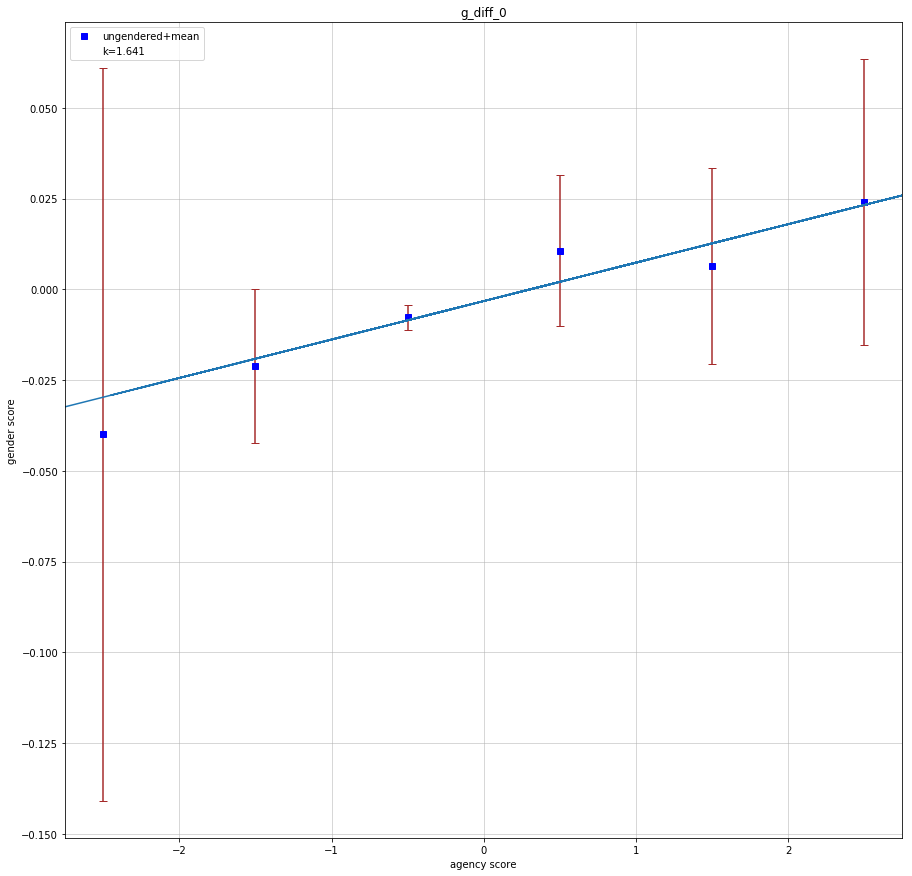

In [63]:
# agency plot g_diff
'''
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(np.arange(-2.5,3,1), ag_avg_proj_g_diff, linewidth=0, marker='s', color='blue', label='ungendered+mean')

ymins = []
ymaxs = []
for i in range(len(ag_ext_g_diff)):
    if ag_ext_g_diff[i] < 0:
        print("warning: negative extension value")
    ymins.append(ag_avg_proj_g_diff[i]-ag_ext_g_diff[i]/2)
    ymaxs.append(ag_avg_proj_g_diff[i]+ag_ext_g_diff[i]/2)

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

#ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
xlims = plt.xlim()
x = [i for i in ag_com_mean_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x), label=line)
plt.xlim(xlims)

score_max = np.max(ag_com_mean_col5)
score_min = np.min(ag_com_mean_col5)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_ag_g_diff = avg_diff_g_diff/line_delta
plt.plot([], [], ' ', label=f'k={k_ag_g_diff:1.3f}')

ax.set_xlabel('agency score')
ax.set_ylabel('gender score')
ax.set_title("g_diff_0")
ax.legend()
'''

slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(np.arange(-2.5,3,1), ag_avg_proj_g_diff, linewidth=0, marker='s', color='blue', label='ungendered+mean')

ymins = []
ymaxs = []
for i in range(len(ag_ext_g_diff)):
    if ag_ext_g_diff[i] < 0:
        print("warning: negative extension value")
    ymins.append(ag_avg_proj_g_diff[i]-ag_ext_g_diff[i]/2)
    ymaxs.append(ag_avg_proj_g_diff[i]+ag_ext_g_diff[i]/2)

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

#ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)
xlims = plt.xlim()
x = [i for i in ag_com_mean_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)

score_max = np.max(ag_com_mean_col5)
score_min = np.min(ag_com_mean_col5)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_ag_g_diff = avg_diff_g_diff/line_delta
plt.plot([], [], ' ', label=f'k={k_ag_g_diff:1.3f}')

ax.set_xlabel('agency score')
ax.set_ylabel('gender score')
ax.set_title("g_diff_0")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/ag/ft_deb_g_diff.pdf', bbox_inches='tight', format='pdf')

0.049226302718503416


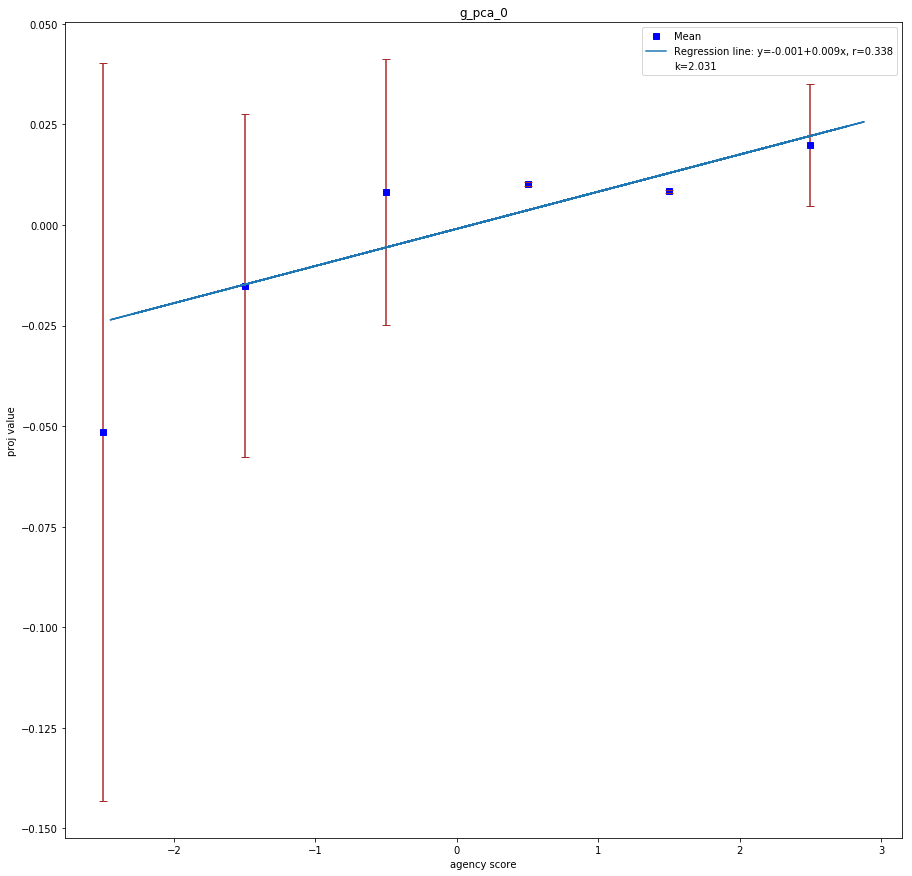

In [72]:
# agency plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col2)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), ag_avg_proj_g_pca_0, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(ag_ext_g_pca_0)):
    if ag_ext_g_pca_0[i] < 0:
        print("warning: negative extension value")
    ymins.append(ag_avg_proj_g_pca_0[i]-ag_ext_g_pca_0[i]/2)
    ymaxs.append(ag_avg_proj_g_pca_0[i]+ag_ext_g_pca_0[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)

score_max = np.max(ag_com_mean_col5)
score_min = np.min(ag_com_mean_col5)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_ag_g_pca_0 = avg_diff_g_pca_0/line_delta
plt.plot([], [], ' ', label=f'k={k_ag_g_pca_0:1.3f}')

ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/ag/ft_deb_g_pca_0')

0.03194358633771315


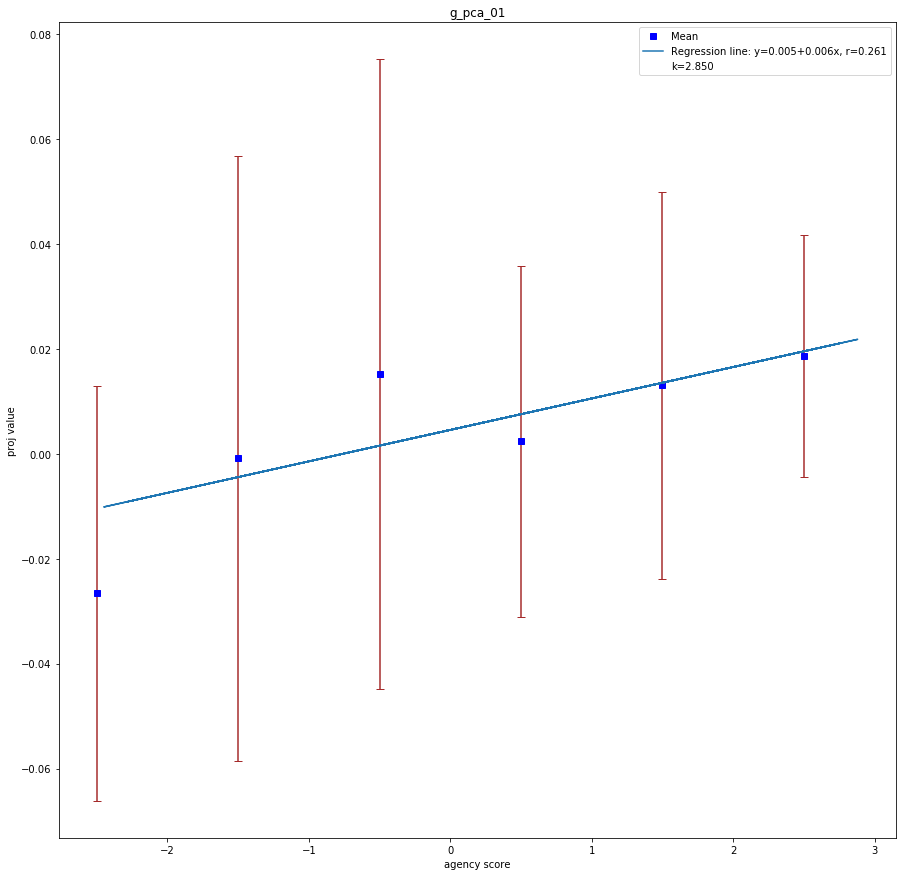

In [73]:
# agency plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col3)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), ag_avg_proj_g_pca_01, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(ag_ext_g_pca_01)):
    if ag_ext_g_pca_01[i] < 0:
        print("warning: negative extension value")
    ymins.append(ag_avg_proj_g_pca_01[i]-ag_ext_g_pca_01[i]/2)
    ymaxs.append(ag_avg_proj_g_pca_01[i]+ag_ext_g_pca_01[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)

score_max = np.max(ag_com_mean_col5)
score_min = np.min(ag_com_mean_col5)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_ag_g_pca_01 = avg_diff_g_pca_01/line_delta
plt.plot([], [], ' ', label=f'k={k_ag_g_pca_01:1.3f}')

ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/ag/ft_deb_g_pca_01')

-1.879729581391945e-05


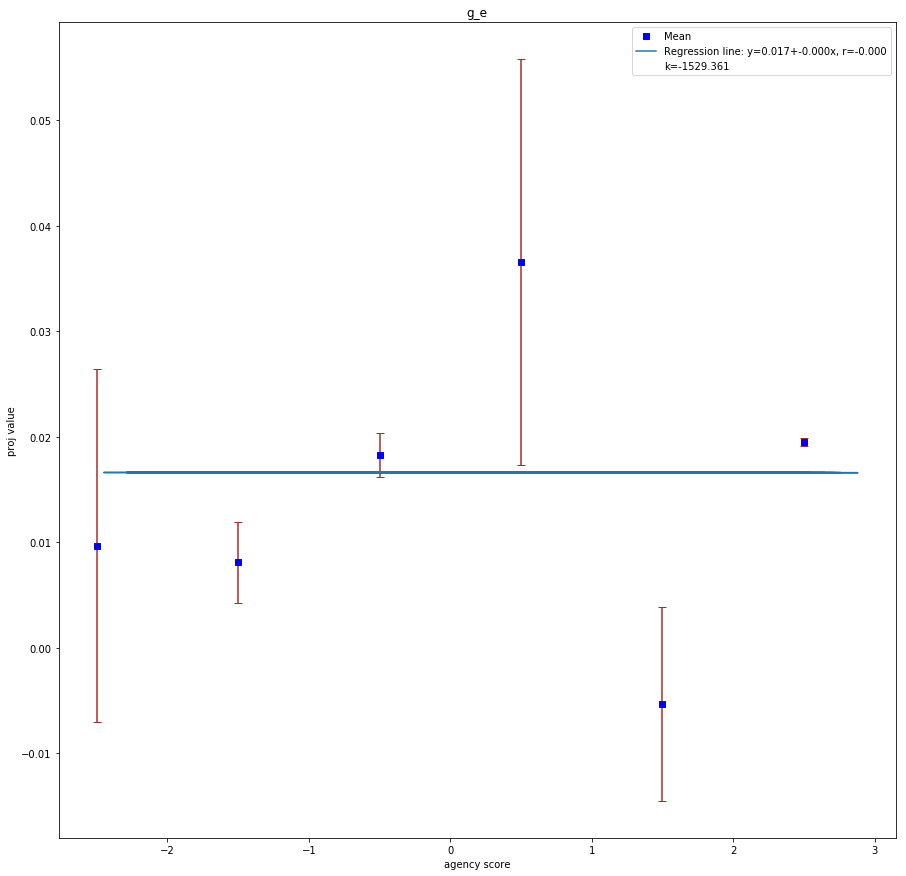

In [74]:
# agency plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col4)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), ag_avg_proj_g_e, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(ag_ext_g_e)):
    if ag_ext_g_e[i] < 0:
        print("warning: negative extension value")
    ymins.append(ag_avg_proj_g_e[i]-ag_ext_g_e[i]/2)
    ymaxs.append(ag_avg_proj_g_e[i]+ag_ext_g_e[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)

score_max = np.max(ag_com_mean_col5)
score_min = np.min(ag_com_mean_col5)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_ag_g_e = avg_diff_g_e/line_delta
plt.plot([], [], ' ', label=f'k={k_ag_g_e:1.3f}')

ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/ag/ft_deb_g_e')

-0.002757214166840218


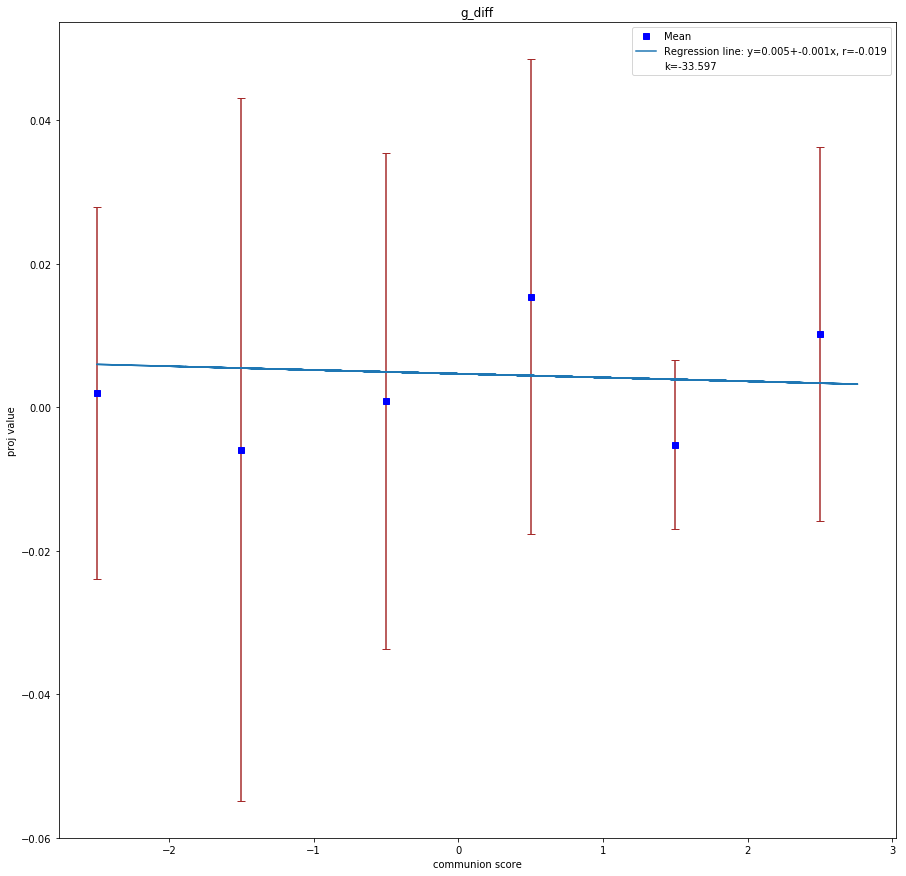

In [75]:
# communion plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col1)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), com_avg_proj_g_diff, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(com_ext_g_diff)):
    if com_ext_g_diff[i] < 0:
        print("warning: negative extension value")
    ymins.append(com_avg_proj_g_diff[i]-com_ext_g_diff[i]/2)
    ymaxs.append(com_avg_proj_g_diff[i]+com_ext_g_diff[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)

score_max = np.max(ag_com_mean_col6)
score_min = np.min(ag_com_mean_col6)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_com_g_diff = avg_diff_g_diff/line_delta
plt.plot([], [], ' ', label=f'k={k_com_g_diff:1.3f}')

ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/com/ft_deb_g_diff')

0.020950144108806183


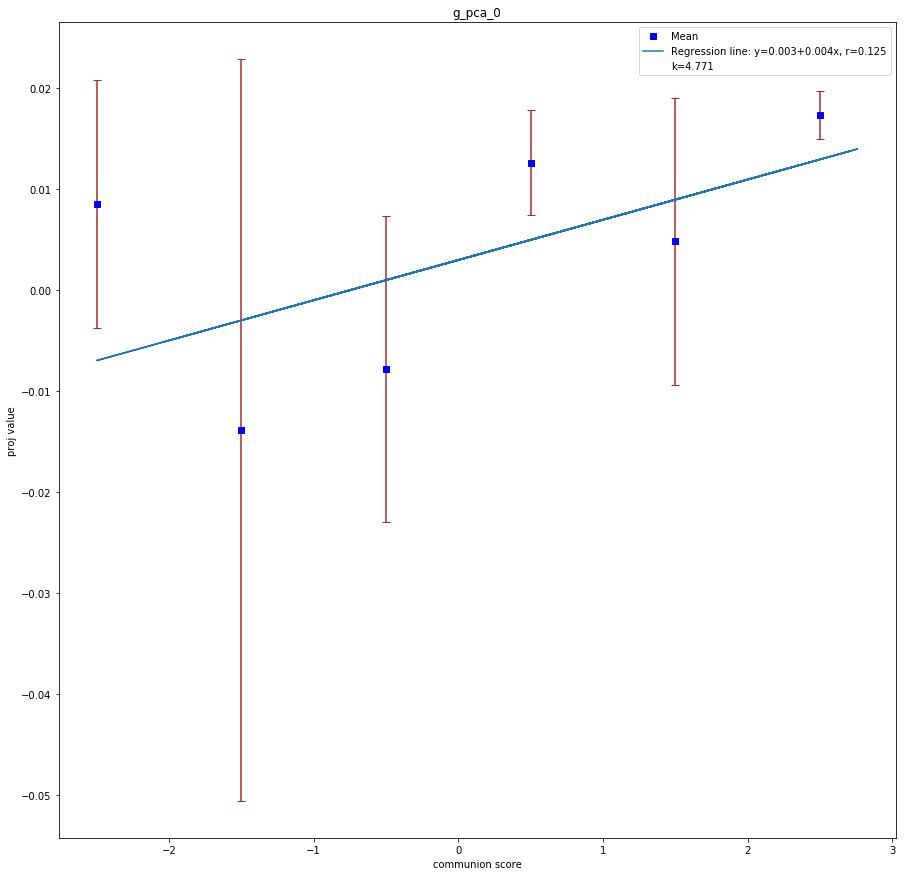

In [76]:
# communion plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col2)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), com_avg_proj_g_pca_0, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(com_ext_g_pca_0)):
    if com_ext_g_pca_0[i] < 0:
        print("warning: negative extension value")
    ymins.append(com_avg_proj_g_pca_0[i]-com_ext_g_pca_0[i]/2)
    ymaxs.append(com_avg_proj_g_pca_0[i]+com_ext_g_pca_0[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)

score_max = np.max(ag_com_mean_col6)
score_min = np.min(ag_com_mean_col6)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_com_g_pca_0 = avg_diff_g_pca_0/line_delta
plt.plot([], [], ' ', label=f'k={k_com_g_pca_0:1.3f}')

ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/com/ft_deb_g_pca_0')

0.007660922797262354


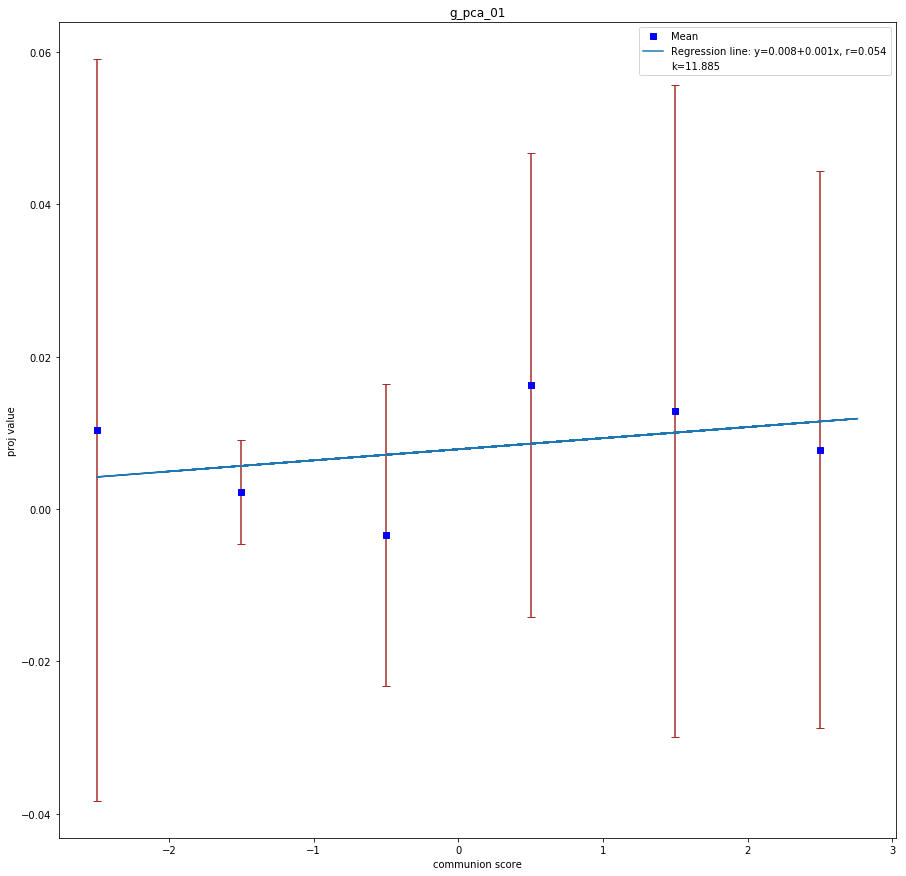

In [77]:
# communion plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col3)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), com_avg_proj_g_pca_01, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(com_ext_g_pca_01)):
    if com_ext_g_pca_01[i] < 0:
        print("warning: negative extension value")
    ymins.append(com_avg_proj_g_pca_01[i]-com_ext_g_pca_01[i]/2)
    ymaxs.append(com_avg_proj_g_pca_01[i]+com_ext_g_pca_01[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)

score_max = np.max(ag_com_mean_col6)
score_min = np.min(ag_com_mean_col6)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_com_g_pca_01 = avg_diff_g_pca_01/line_delta
plt.plot([], [], ' ', label=f'k={k_com_g_pca_01:1.3f}')

ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/com/ft_deb_g_pca_01')

0.008335167074711016


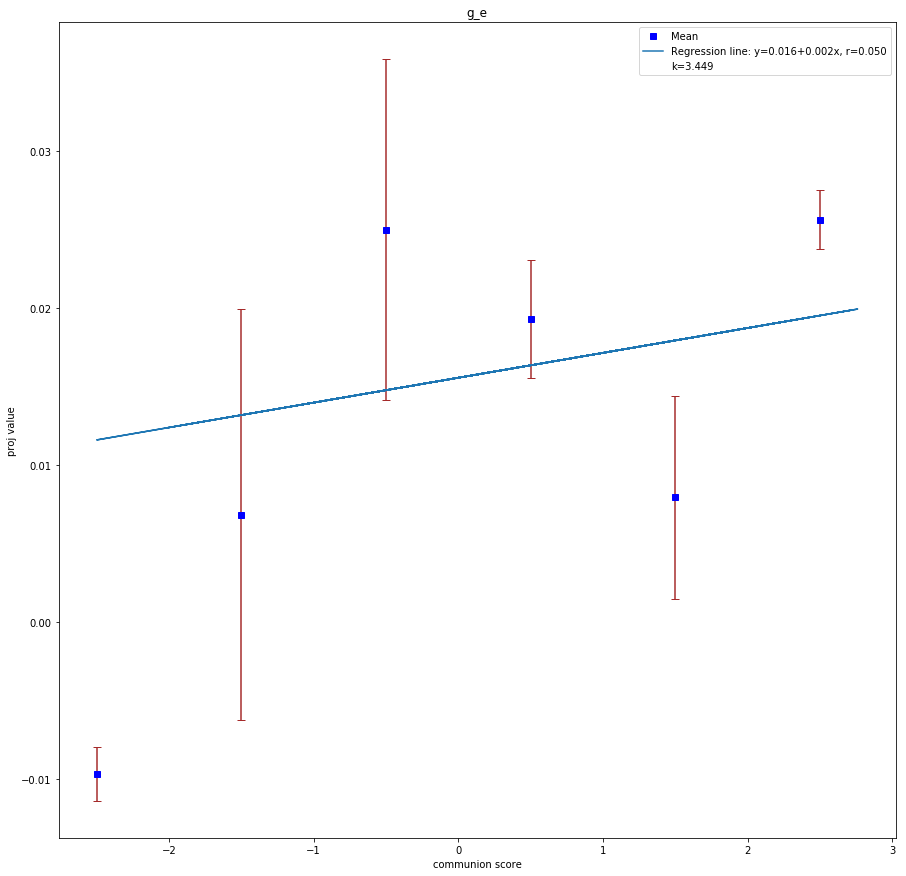

In [78]:
# communion plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col4)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), com_avg_proj_g_e, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(com_ext_g_e)):
    if com_ext_g_e[i] < 0:
        print("warning: negative extension value")
    ymins.append(com_avg_proj_g_e[i]-com_ext_g_e[i]/2)
    ymaxs.append(com_avg_proj_g_e[i]+com_ext_g_e[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)

score_max = np.max(ag_com_mean_col6)
score_min = np.min(ag_com_mean_col6)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
print(line_delta)
k_com_g_e = avg_diff_g_e/line_delta
plt.plot([], [], ' ', label=f'k={k_com_g_e:1.3f}')

ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/com/ft_deb_g_e')

In [79]:
# print k
print('k_ag_g_diff:    %6.3lf' % (k_ag_g_diff))
print('k_ag_g_pca_0:   %6.3f' % (k_ag_g_pca_0))
print('k_ag_g_pca_01:  %6.3f' % (k_ag_g_pca_01))
print('k_ag_g_e:       %6.3f' % (k_ag_g_e))
print()
print('k_com_g_diff:   %6.3f' % (k_com_g_diff))
print('k_com_g_pca_0:  %6.3f' % (k_com_g_pca_0))
print('k_com_g_pca_01: %6.3f' % (k_com_g_pca_01))
print('k_com_g_e:      %6.3f' % (k_com_g_e))

k_ag_g_diff:     1.641
k_ag_g_pca_0:    2.031
k_ag_g_pca_01:   2.850
k_ag_g_e:       -1529.361

k_com_g_diff:   -33.597
k_com_g_pca_0:   4.771
k_com_g_pca_01: 11.885
k_com_g_e:       3.449


### Step 3: working with Gonen's embeddings

#### Step 3.1: repeating steps 2.1-2.5

In [102]:
# gender direction
g_diff = E_g.diff('lui', 'lei')

In [103]:
# list of pairs to define gender
gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [104]:
# PCA
pca = we.doPCA(gender_pairs, E_g)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [105]:
print("Singular values:")
print(sv)

Singular values:
[6.73165823e-01 4.74985087e-01 4.38029897e-01 3.35332203e-01
 2.90767211e-01 2.36732569e-01 1.27794811e-16 1.13799029e-16
 9.10948385e-17 8.73430101e-17]


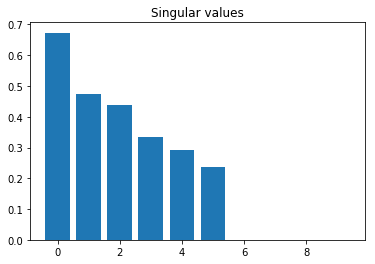

In [106]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [107]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

In [108]:
S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [109]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_g.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_g.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_g.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_g.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [110]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [111]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

##### Ungendered

In [112]:
# words
ag_com_ung = db.read('ag_com_ung_ita.txt', 'ag-com-mf')

In [113]:
# compute projections
# all words ungendered
proj_ag_com_ung_g_diff =  db.prof_proj(E_g, ag_com_ung, g_diff, 'ag-com-m')
proj_ag_com_ung_g_pca_0 =  db.prof_proj(E_g, ag_com_ung, g_pca_0, 'ag-com-m')
proj_ag_com_ung_g_pca_01 =  db.prof_proj(E_g, ag_com_ung, g_pca_01, 'ag-com-m')
proj_ag_com_ung_g_e =  db.prof_proj(E_g, ag_com_ung, g_e, 'ag-com-m')

In [114]:
# print ag_com_ung results
ag_com_ung_col0 = [] # pandas columns
ag_com_ung_col1 = []
ag_com_ung_col2 = []
ag_com_ung_col3 = []
ag_com_ung_col4 = []
ag_com_ung_col5 = []
ag_com_ung_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_ung_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_ung_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_ung_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_ung_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_ung_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_ung_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_ung_col6.append(proj_ag_com_ung_g_diff[i][3])

ag_com_ung_data = {'Word':ag_com_ung_col0, 
               'Proj g_diff':ag_com_ung_col1,
               'Proj g_pca_0':ag_com_ung_col2, 
               'Proj g_pca_01':ag_com_ung_col3,
               'Proj g_e':ag_com_ung_col4,
               'Agency':ag_com_ung_col5,
               'Communion':ag_com_ung_col6}

ag_com_ung_table = pd.DataFrame(ag_com_ung_data)
ag_com_ung_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency,Communion
0,abile,0.059056,-0.113135,-0.023355,0.112070,2.32,0.66
1,altruista,-0.115441,-0.013627,0.008819,0.065061,-1.18,2.50
2,capace,0.026271,-0.020479,-0.026877,0.053098,2.45,1.08
3,competente,0.059333,-0.066472,-0.013275,0.059932,2.21,0.61
4,coerente,0.021684,-0.035207,-0.037364,-0.014060,0.74,1.68
5,dominante,-0.032145,-0.024013,0.036617,-0.024821,2.76,-1.89
6,amichevole,-0.011846,0.081167,0.099525,0.031213,0.15,2.23
7,disponibile,-0.116799,0.034990,0.024886,0.017821,-0.42,2.76
8,egoista,-0.161264,-0.018887,-0.032528,0.085321,1.53,-2.50
9,indipendente,-0.001864,0.028230,0.034211,-0.044919,2.65,-0.83


##### Gendered words

In [115]:
# words
ag_com_gen = db.read('ag_com_gen_ita.txt', 'ag-com-mf')

In [116]:
# compute projections
# male
proj_ag_com_gen_m_g_diff =  db.prof_proj(E_g, ag_com_gen, g_diff, 'ag-com-m')
proj_ag_com_gen_m_g_pca_0 =  db.prof_proj(E_g, ag_com_gen, g_pca_0, 'ag-com-m')
proj_ag_com_gen_m_g_pca_01 =  db.prof_proj(E_g, ag_com_gen, g_pca_01, 'ag-com-m')
proj_ag_com_gen_m_g_e =  db.prof_proj(E_g, ag_com_gen, g_e, 'ag-com-m')

# female
proj_ag_com_gen_f_g_diff =  db.prof_proj(E_g, ag_com_gen, g_diff, 'ag-com-f')
proj_ag_com_gen_f_g_pca_0 =  db.prof_proj(E_g, ag_com_gen, g_pca_0, 'ag-com-f')
proj_ag_com_gen_f_g_pca_01 =  db.prof_proj(E_g, ag_com_gen, g_pca_01, 'ag-com-f')
proj_ag_com_gen_f_g_e =  db.prof_proj(E_g, ag_com_gen, g_e, 'ag-com-f')

In [117]:
# print ag_com_gen_m results
ag_com_gen_m_col0 = [] # pandas columns
ag_com_gen_m_col1 = []
ag_com_gen_m_col2 = []
ag_com_gen_m_col3 = []
ag_com_gen_m_col4 = []
ag_com_gen_m_col5 = []
ag_com_gen_m_col6 = []

for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_gen_m_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_gen_m_col1.append(proj_ag_com_gen_m_g_diff[i][1]) # projection on g_diff
    ag_com_gen_m_col2.append(proj_ag_com_gen_m_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_m_col3.append(proj_ag_com_gen_m_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_m_col4.append(np.real(proj_ag_com_gen_m_g_e[i][1])) # projection on g_e
    ag_com_gen_m_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_gen_m_col6.append(proj_ag_com_gen_m_g_diff[i][3])

ag_com_gen_m_data = {'Word':ag_com_gen_m_col0, 
               'Proj g_diff':ag_com_gen_m_col1,
               'Proj g_pca_0':ag_com_gen_m_col2, 
               'Proj g_pca_01':ag_com_gen_m_col3,
               'Proj g_e':ag_com_gen_m_col4,
               'Agency':ag_com_gen_m_col5,
               'Communion':ag_com_gen_m_col6}

ag_com_gen_m_table = pd.DataFrame(ag_com_gen_m_data)
ag_com_gen_m_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency,Communion
0,attivo,0.017886,-0.094562,-0.052168,0.032997,2.35,1.55
1,affettuoso,-0.127809,0.016065,0.070109,0.013732,-0.85,1.58
2,ambizioso,0.000125,-0.104148,-0.052351,-0.001439,2.79,-0.97
3,deciso,-0.119423,0.033008,0.027678,0.012721,2.88,0.43
4,vanitoso,-0.155557,0.034814,0.046701,0.006040,1.29,-1.18
5,confusionario,-0.049710,-0.057565,-0.044746,0.009453,-1.89,-0.95
6,comunicativo,-0.035811,-0.092983,-0.106942,-0.001147,1.50,2.00
7,competitivo,0.018908,-0.112277,-0.080623,-0.028378,2.71,-1.39
8,presuntuoso,-0.083870,-0.013392,0.018782,0.028906,1.53,-1.50
9,coscienzioso,0.005012,-0.114055,-0.072775,-0.045004,0.58,1.32


In [118]:
# print ag_com_gen_f results
ag_com_gen_f_col0 = [] # pandas columns
ag_com_gen_f_col1 = []
ag_com_gen_f_col2 = []
ag_com_gen_f_col3 = []
ag_com_gen_f_col4 = []
ag_com_gen_f_col5 = []
ag_com_gen_f_col6 = []

for i in range(len(proj_ag_com_gen_f_g_diff)):
    ag_com_gen_f_col0.append(proj_ag_com_gen_f_g_diff[i][0]) # word
    ag_com_gen_f_col1.append(proj_ag_com_gen_f_g_diff[i][1]) # projection on g_diff
    ag_com_gen_f_col2.append(proj_ag_com_gen_f_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_gen_f_col3.append(proj_ag_com_gen_f_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_gen_f_col4.append(np.real(proj_ag_com_gen_f_g_e[i][1])) # projection on g_e
    ag_com_gen_f_col5.append(proj_ag_com_gen_f_g_diff[i][2])
    ag_com_gen_f_col6.append(proj_ag_com_gen_f_g_diff[i][3])

ag_com_gen_f_data = {'Word':ag_com_gen_f_col0, 
               'Proj g_diff':ag_com_gen_f_col1,
               'Proj g_pca_0':ag_com_gen_f_col2, 
               'Proj g_pca_01':ag_com_gen_f_col3,
               'Proj g_e':ag_com_gen_f_col4,
               'Agency':ag_com_gen_f_col5,
               'Communion':ag_com_gen_f_col6}

ag_com_gen_f_table = pd.DataFrame(ag_com_gen_f_data)
ag_com_gen_f_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency,Communion
0,attiva,-0.091514,0.062616,0.050867,-0.009358,2.35,1.55
1,affettuosa,-0.208138,0.200039,0.210236,0.064931,-0.85,1.58
2,ambiziosa,-0.105657,0.130300,0.099913,0.045116,2.79,-0.97
3,decisa,-0.063146,0.062105,0.067235,0.106478,2.88,0.43
4,vanitosa,-0.273848,0.211621,0.191887,0.033542,1.29,-1.18
5,confusionaria,-0.051784,0.068063,0.037947,-0.000608,-1.89,-0.95
6,comunicativa,-0.072940,0.020775,-0.013059,0.005213,1.50,2.00
7,competitiva,-0.032508,0.039127,0.019015,-0.059104,2.71,-1.39
8,presuntuosa,-0.163381,0.087191,0.079845,0.031777,1.53,-1.50
9,rispettosa,-0.012484,0.021559,0.036902,0.062257,-0.35,1.55


In [119]:
# fom (female over male): % of words with female proj > male proj
n_g_diff = 0
n_g_pca_0 = 0
n_g_pca_01 = 0
n_g_e = 0

for i in range(len(ag_com_gen_m_col0)):
    if ag_com_gen_f_col1[i] > ag_com_gen_m_col1[i]:
        n_g_diff += 1
        
    if ag_com_gen_f_col2[i] > ag_com_gen_m_col2[i]:
        n_g_pca_0 += 1

    if ag_com_gen_f_col3[i] > ag_com_gen_m_col3[i]:
        n_g_pca_01 += 1

    if ag_com_gen_f_col4[i] > ag_com_gen_m_col4[i]:
        n_g_e += 1

fom_g_diff = n_g_diff/len(ag_com_gen_m_col0)*100
fom_g_pca_0 = n_g_pca_0/len(ag_com_gen_m_col0)*100
fom_g_pca_01 = n_g_pca_01/len(ag_com_gen_m_col0)*100
fom_g_e = n_g_e/len(ag_com_gen_m_col0)*100

In [120]:
print("fom_g_diff:   %5.2f %%" % (fom_g_diff))
print("fom_g_pca_0:  %5.2f %%" % (fom_g_pca_0))
print("fom_g_pca_01: %5.2f %%" % (fom_g_pca_01))
print("fom_g_e:      %5.2f %%" % (fom_g_e))

fom_g_diff:   16.67 %
fom_g_pca_0:  97.22 %
fom_g_pca_01: 88.89 %
fom_g_e:      61.11 %


##### Ungendered + mean gendered words

In [121]:
# print ag_com_mean results
ag_com_mean_col0 = [] # pandas columns
ag_com_mean_col1 = []
ag_com_mean_col2 = []
ag_com_mean_col3 = []
ag_com_mean_col4 = []
ag_com_mean_col5 = []
ag_com_mean_col6 = []

for i in range(len(proj_ag_com_ung_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_ung_g_diff[i][0]) # word
    ag_com_mean_col1.append(proj_ag_com_ung_g_diff[i][1]) # projection on g_diff
    ag_com_mean_col2.append(proj_ag_com_ung_g_pca_0[i][1]) # projection on g_pca_0
    ag_com_mean_col3.append(proj_ag_com_ung_g_pca_01[i][1]) # projection on g_pca_01
    ag_com_mean_col4.append(np.real(proj_ag_com_ung_g_e[i][1])) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_ung_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_ung_g_diff[i][3])
    
for i in range(len(proj_ag_com_gen_m_g_diff)):
    ag_com_mean_col0.append(proj_ag_com_gen_m_g_diff[i][0]) # word
    ag_com_mean_col1.append((proj_ag_com_gen_m_g_diff[i][1]+proj_ag_com_gen_f_g_diff[i][1])/2) # projection on g_diff
    ag_com_mean_col2.append((proj_ag_com_gen_m_g_pca_0[i][1]+proj_ag_com_gen_f_g_pca_0[i][1])/2) # projection on g_pca_0
    ag_com_mean_col3.append((proj_ag_com_gen_m_g_pca_01[i][1]+proj_ag_com_gen_f_g_pca_01[i][1])/2) # projection on g_pca_01
    ag_com_mean_col4.append((np.real(proj_ag_com_gen_m_g_e[i][1])+np.real(proj_ag_com_gen_f_g_e[i][1]))/2) # projection on g_e
    ag_com_mean_col5.append(proj_ag_com_gen_m_g_diff[i][2])
    ag_com_mean_col6.append(proj_ag_com_gen_m_g_diff[i][3])   

ag_com_mean_data = {'Word':ag_com_mean_col0, 
               'Proj g_diff':ag_com_mean_col1,
               'Proj g_pca_0':ag_com_mean_col2, 
               'Proj g_pca_01':ag_com_mean_col3,
               'Proj g_e':ag_com_mean_col4,
               'Agency':ag_com_mean_col5,
               'Communion':ag_com_mean_col6}

ag_com_mean_table = pd.DataFrame(ag_com_mean_data)
ag_com_mean_table

,Word,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Proj g_e,Agency,Communion
0,abile,0.059056,-0.113135,-0.023355,0.112070,2.32,0.66
1,altruista,-0.115441,-0.013627,0.008819,0.065061,-1.18,2.50
2,capace,0.026271,-0.020479,-0.026877,0.053098,2.45,1.08
3,competente,0.059333,-0.066472,-0.013275,0.059932,2.21,0.61
4,coerente,0.021684,-0.035207,-0.037364,-0.014060,0.74,1.68
5,dominante,-0.032145,-0.024013,0.036617,-0.024821,2.76,-1.89
6,amichevole,-0.011846,0.081167,0.099525,0.031213,0.15,2.23
7,disponibile,-0.116799,0.034990,0.024886,0.017821,-0.42,2.76
8,egoista,-0.161264,-0.018887,-0.032528,0.085321,1.53,-2.50
9,indipendente,-0.001864,0.028230,0.034211,-0.044919,2.65,-0.83


In [122]:
# agency gendered subsets
gen_group_0_ag = [] # -3 <= ag < -2
gen_group_1_ag = [] # -2 <= ag < -1
gen_group_2_ag = [] # -1 <= ag < 0
gen_group_3_ag = [] # 0 <= ag < 1
gen_group_4_ag = [] # 1 <= ag < 2
gen_group_5_ag = [] # 2 <= ag <= 3

for i in range(len(ag_com_gen_m_col0)):
    score = ag_com_gen_m_col5[i]
    item = [ag_com_gen_m_col0[i], 
            ag_com_gen_m_col1[i]-ag_com_gen_f_col1[i], 
            ag_com_gen_m_col2[i]-ag_com_gen_f_col2[i],
            ag_com_gen_m_col3[i]-ag_com_gen_f_col3[i],
            ag_com_gen_m_col4[i]-ag_com_gen_f_col4[i],
            score]
    if score < -2:
        gen_group_0_ag.append(item)
    
    elif score >= -2 and score < -1:
        gen_group_1_ag.append(item)
        
    elif score >= -1 and score < 0:
        gen_group_2_ag.append(item)

    elif score >= 0 and score < 1:
        gen_group_3_ag.append(item)

    elif score >= 1 and score < 2:
        gen_group_4_ag.append(item)

    elif score >= 2:
        gen_group_5_ag.append(item)

        
# communion gendered subsets
gen_group_0_com = [] # -3 <= com < -2
gen_group_1_com = [] # -2 <= com < -1
gen_group_2_com = [] # -1 <= com < 0
gen_group_3_com = [] # 0 <= com < 1
gen_group_4_com = [] # 1 <= com < 2
gen_group_5_com = [] # 2 <= com <= 3

for i in range(len(ag_com_gen_m_col0)):
    score = ag_com_gen_m_col6[i]
    item = [ag_com_gen_m_col0[i], 
            ag_com_gen_m_col1[i]-ag_com_gen_f_col1[i], 
            ag_com_gen_m_col2[i]-ag_com_gen_f_col2[i],
            ag_com_gen_m_col3[i]-ag_com_gen_f_col3[i],
            ag_com_gen_m_col4[i]-ag_com_gen_f_col4[i],
            score]
    if score < -2:
        gen_group_0_com.append(item)
    
    elif score >= -2 and score < -1:
        gen_group_1_com.append(item)
        
    elif score >= -1 and score < 0:
        gen_group_2_com.append(item)

    elif score >= 0 and score < 1:
        gen_group_3_com.append(item)

    elif score >= 1 and score < 2:
        gen_group_4_com.append(item)

    elif score >= 2:
        gen_group_5_com.append(item)

In [123]:
# agency subgroup average differences of gendered projections
group_0_ag_ext = compute_avg(gen_group_0_ag)
group_1_ag_ext = compute_avg(gen_group_1_ag)
group_2_ag_ext = compute_avg(gen_group_2_ag)
group_3_ag_ext = compute_avg(gen_group_3_ag)
group_4_ag_ext = compute_avg(gen_group_4_ag)
group_5_ag_ext = compute_avg(gen_group_5_ag)

# communion subgroup average differences of gendered projections
group_0_com_ext = compute_avg(gen_group_0_com)
group_1_com_ext = compute_avg(gen_group_1_com)
group_2_com_ext = compute_avg(gen_group_2_com)
group_3_com_ext = compute_avg(gen_group_3_com)
group_4_com_ext = compute_avg(gen_group_4_com)
group_5_com_ext = compute_avg(gen_group_5_com)

In [124]:
# agency mean (ung + mean gendered) subsets
mean_group_0_ag = [] # -3 <= ag < -2
mean_group_1_ag = [] # -2 <= ag < -1
mean_group_2_ag = [] # -1 <= ag < 0
mean_group_3_ag = [] # 0 <= ag < 1
mean_group_4_ag = [] # 1 <= ag < 2
mean_group_5_ag = [] # 2 <= ag <= 3

for i in range(len(ag_com_mean_col0)):
    score = ag_com_mean_col5[i]
    item = [ag_com_mean_col0[i], 
            ag_com_mean_col1[i], 
            ag_com_mean_col2[i],
            ag_com_mean_col3[i],
            ag_com_mean_col4[i],
            score]
    if score < -2:
        mean_group_0_ag.append(item)
    
    elif score >= -2 and score < -1:
        mean_group_1_ag.append(item)
        
    elif score >= -1 and score < 0:
        mean_group_2_ag.append(item)

    elif score >= 0 and score < 1:
        mean_group_3_ag.append(item)

    elif score >= 1 and score < 2:
        mean_group_4_ag.append(item)

    elif score >= 2:
        mean_group_5_ag.append(item)

        
# communion mean (ung + mean gendered) subsets
mean_group_0_com = [] # -3 <= com < -2
mean_group_1_com = [] # -2 <= com < -1
mean_group_2_com = [] # -1 <= com < 0
mean_group_3_com = [] # 0 <= com < 1
mean_group_4_com = [] # 1 <= com < 2
mean_group_5_com = [] # 2 <= com <= 3

for i in range(len(ag_com_mean_col0)):
    score = ag_com_mean_col6[i]
    item = [ag_com_mean_col0[i], 
            ag_com_mean_col1[i], 
            ag_com_mean_col2[i],
            ag_com_mean_col3[i],
            ag_com_mean_col4[i],
            score]
    if score < -2:
        mean_group_0_com.append(item)
    
    elif score >= -2 and score < -1:
        mean_group_1_com.append(item)
        
    elif score >= -1 and score < 0:
        mean_group_2_com.append(item)

    elif score >= 0 and score < 1:
        mean_group_3_com.append(item)

    elif score >= 1 and score < 2:
        mean_group_4_com.append(item)

    elif score >= 2:
        mean_group_5_com.append(item)

In [125]:
# agency subgroup average projection
group_0_ag_avg_proj = compute_avg(mean_group_0_ag)
group_1_ag_avg_proj = compute_avg(mean_group_1_ag)
group_2_ag_avg_proj = compute_avg(mean_group_2_ag)
group_3_ag_avg_proj = compute_avg(mean_group_3_ag)
group_4_ag_avg_proj = compute_avg(mean_group_4_ag)
group_5_ag_avg_proj = compute_avg(mean_group_5_ag)

# communion subgroup average projection
group_0_com_avg_proj = compute_avg(mean_group_0_com)
group_1_com_avg_proj = compute_avg(mean_group_1_com)
group_2_com_avg_proj = compute_avg(mean_group_2_com)
group_3_com_avg_proj = compute_avg(mean_group_3_com)
group_4_com_avg_proj = compute_avg(mean_group_4_com)
group_5_com_avg_proj = compute_avg(mean_group_5_com)

In [126]:
# avg difference between male and female projection
avg_diff_g_diff = np.mean(np.absolute(np.array(ag_com_gen_m_col1) - np.array(ag_com_gen_f_col1)))
avg_diff_g_pca_0 = np.mean(np.absolute(np.array(ag_com_gen_m_col2) - np.array(ag_com_gen_f_col2)))
avg_diff_g_pca_01 = np.mean(np.absolute(np.array(ag_com_gen_m_col3) - np.array(ag_com_gen_f_col3)))
avg_diff_g_e = np.mean(np.absolute(np.array(ag_com_gen_m_col4) - np.array(ag_com_gen_f_col4)))

In [127]:
print("avg_diff_g_diff:   %1.3f" % (avg_diff_g_diff))
print("avg_diff_g_pca_0:  %1.3f" % (avg_diff_g_pca_0))
print("avg_diff_g_pca_01: %1.3f" % (avg_diff_g_pca_01))
print("avg_diff_g_e:      %1.3f" % (avg_diff_g_e))

avg_diff_g_diff:   0.067
avg_diff_g_pca_0:  0.142
avg_diff_g_pca_01: 0.103
avg_diff_g_e:      0.037


In [128]:
# agency average projections
ag_avg_proj_g_diff = [group_0_ag_avg_proj[0],
                      group_1_ag_avg_proj[0],
                      group_2_ag_avg_proj[0],
                      group_3_ag_avg_proj[0],
                      group_4_ag_avg_proj[0],
                      group_5_ag_avg_proj[0]]

ag_avg_proj_g_pca_0 = [group_0_ag_avg_proj[1],
                      group_1_ag_avg_proj[1],
                      group_2_ag_avg_proj[1],
                      group_3_ag_avg_proj[1],
                      group_4_ag_avg_proj[1],
                      group_5_ag_avg_proj[1]]

ag_avg_proj_g_pca_01 = [group_0_ag_avg_proj[2],
                      group_1_ag_avg_proj[2],
                      group_2_ag_avg_proj[2],
                      group_3_ag_avg_proj[2],
                      group_4_ag_avg_proj[2],
                      group_5_ag_avg_proj[2]]

ag_avg_proj_g_e = [group_0_ag_avg_proj[3],
                      group_1_ag_avg_proj[3],
                      group_2_ag_avg_proj[3],
                      group_3_ag_avg_proj[3],
                      group_4_ag_avg_proj[3],
                      group_5_ag_avg_proj[3]]

# communion average projections
com_avg_proj_g_diff = [group_0_com_avg_proj[0],
                      group_1_com_avg_proj[0],
                      group_2_com_avg_proj[0],
                      group_3_com_avg_proj[0],
                      group_4_com_avg_proj[0],
                      group_5_com_avg_proj[0]]

com_avg_proj_g_pca_0 = [group_0_com_avg_proj[1],
                      group_1_com_avg_proj[1],
                      group_2_com_avg_proj[1],
                      group_3_com_avg_proj[1],
                      group_4_com_avg_proj[1],
                      group_5_com_avg_proj[1]]

com_avg_proj_g_pca_01 = [group_0_com_avg_proj[2],
                      group_1_com_avg_proj[2],
                      group_2_com_avg_proj[2],
                      group_3_com_avg_proj[2],
                      group_4_com_avg_proj[2],
                      group_5_com_avg_proj[2]]

com_avg_proj_g_e = [group_0_com_avg_proj[3],
                      group_1_com_avg_proj[3],
                      group_2_com_avg_proj[3],
                      group_3_com_avg_proj[3],
                      group_4_com_avg_proj[3],
                      group_5_com_avg_proj[3]]

In [129]:
# agency extensions
ag_ext_g_diff = [group_0_ag_ext[0],
                 group_1_ag_ext[0],
                 group_2_ag_ext[0],
                 group_3_ag_ext[0],
                 group_4_ag_ext[0],
                 group_5_ag_ext[0]]

ag_ext_g_pca_0 = [group_0_ag_ext[1],
                 group_1_ag_ext[1],
                 group_2_ag_ext[1],
                 group_3_ag_ext[1],
                 group_4_ag_ext[1],
                 group_5_ag_ext[1]]

ag_ext_g_pca_01 = [group_0_ag_ext[2],
                 group_1_ag_ext[2],
                 group_2_ag_ext[2],
                 group_3_ag_ext[2],
                 group_4_ag_ext[2],
                 group_5_ag_ext[2]]

ag_ext_g_e = [group_0_ag_ext[3],
                 group_1_ag_ext[3],
                 group_2_ag_ext[3],
                 group_3_ag_ext[3],
                 group_4_ag_ext[3],
                 group_5_ag_ext[3]]

# communion extensions
com_ext_g_diff = [group_0_com_ext[0],
                 group_1_com_ext[0],
                 group_2_com_ext[0],
                 group_3_com_ext[0],
                 group_4_com_ext[0],
                 group_5_com_ext[0]]

com_ext_g_pca_0 = [group_0_com_ext[1],
                 group_1_com_ext[1],
                 group_2_com_ext[1],
                 group_3_com_ext[1],
                 group_4_com_ext[1],
                 group_5_com_ext[1]]

com_ext_g_pca_01 = [group_0_com_ext[2],
                 group_1_com_ext[2],
                 group_2_com_ext[2],
                 group_3_com_ext[2],
                 group_4_com_ext[2],
                 group_5_com_ext[2]]

com_ext_g_e = [group_0_com_ext[3],
                 group_1_com_ext[3],
                 group_2_com_ext[3],
                 group_3_com_ext[3],
                 group_4_com_ext[3],
                 group_5_com_ext[3]]

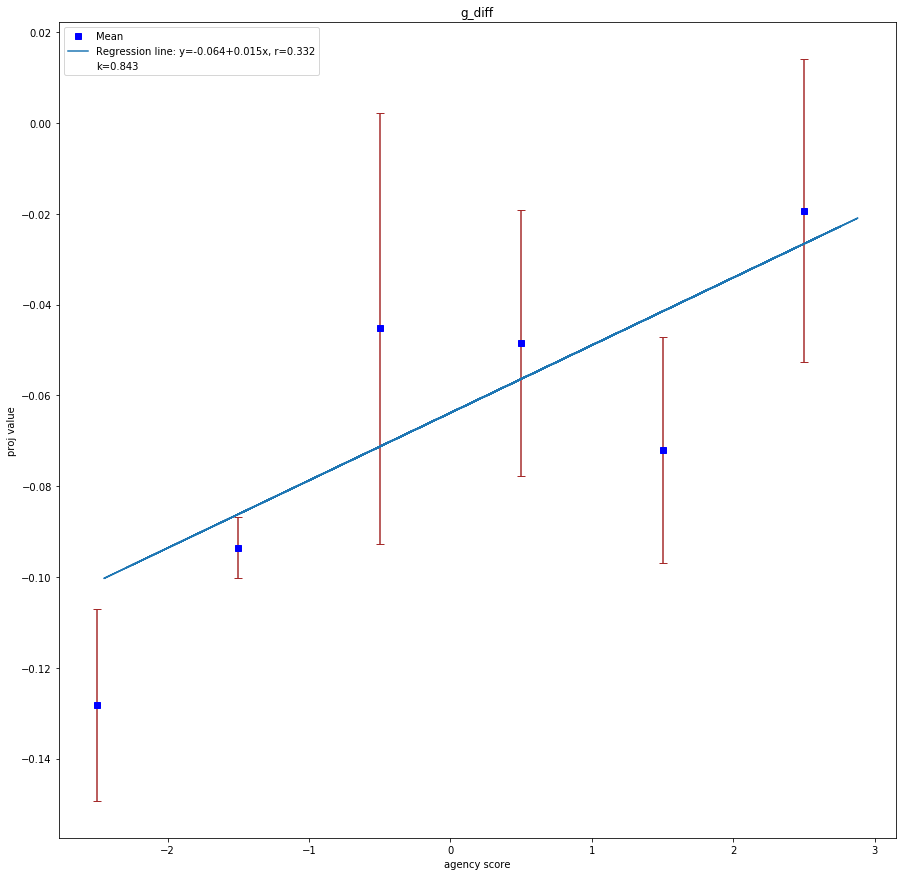

In [130]:
# agency plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col1)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), ag_avg_proj_g_diff, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(ag_ext_g_diff)):
    if ag_ext_g_diff[i] < 0:
        print("warning: negative extension value")
    ymins.append(ag_avg_proj_g_diff[i]-ag_ext_g_diff[i]/2)
    ymaxs.append(ag_avg_proj_g_diff[i]+ag_ext_g_diff[i]/2)

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)

score_max = np.max(ag_com_mean_col5)
score_min = np.min(ag_com_mean_col5)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
k_ag_g_diff = avg_diff_g_diff/line_delta
plt.plot([], [], ' ', label=f'k={k_ag_g_diff:1.3f}')

ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/ag/g_g_diff')

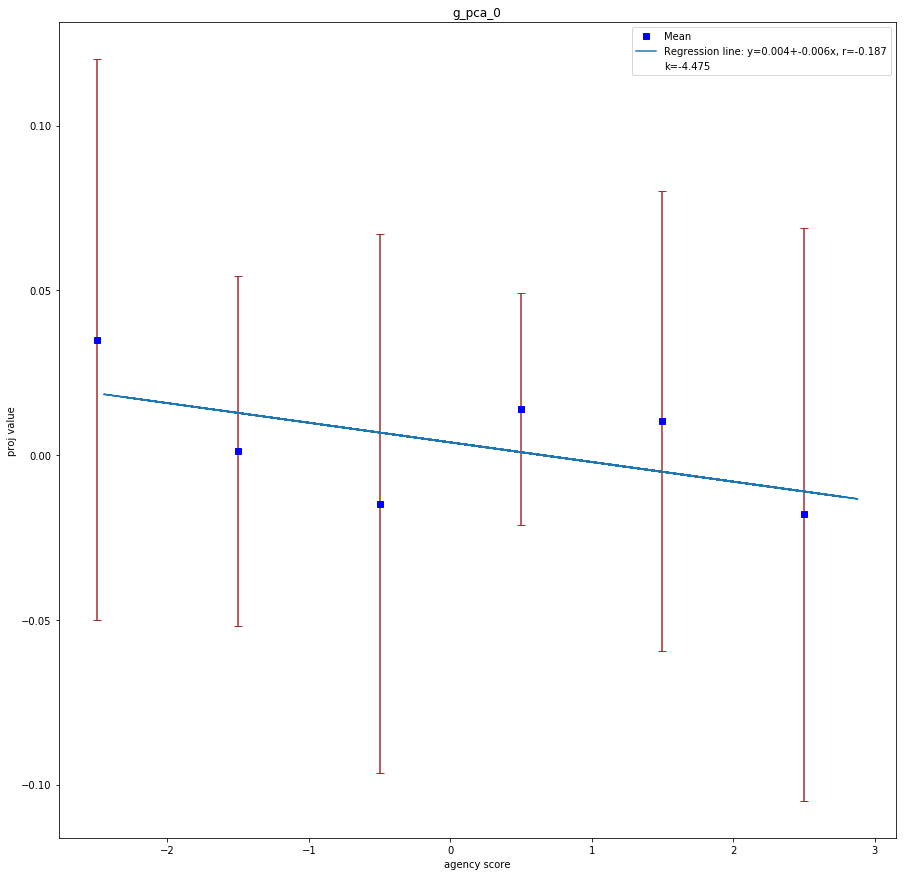

In [131]:
# agency plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col2)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), ag_avg_proj_g_pca_0, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(ag_ext_g_pca_0)):
    if ag_ext_g_pca_0[i] < 0:
        print("warning: negative extension value")
    ymins.append(ag_avg_proj_g_pca_0[i]-ag_ext_g_pca_0[i]/2)
    ymaxs.append(ag_avg_proj_g_pca_0[i]+ag_ext_g_pca_0[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)

score_max = np.max(ag_com_mean_col5)
score_min = np.min(ag_com_mean_col5)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
k_ag_g_pca_0 = avg_diff_g_pca_0/line_delta
plt.plot([], [], ' ', label=f'k={k_ag_g_pca_0:1.3f}')

ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/ag/g_g_pca_0')

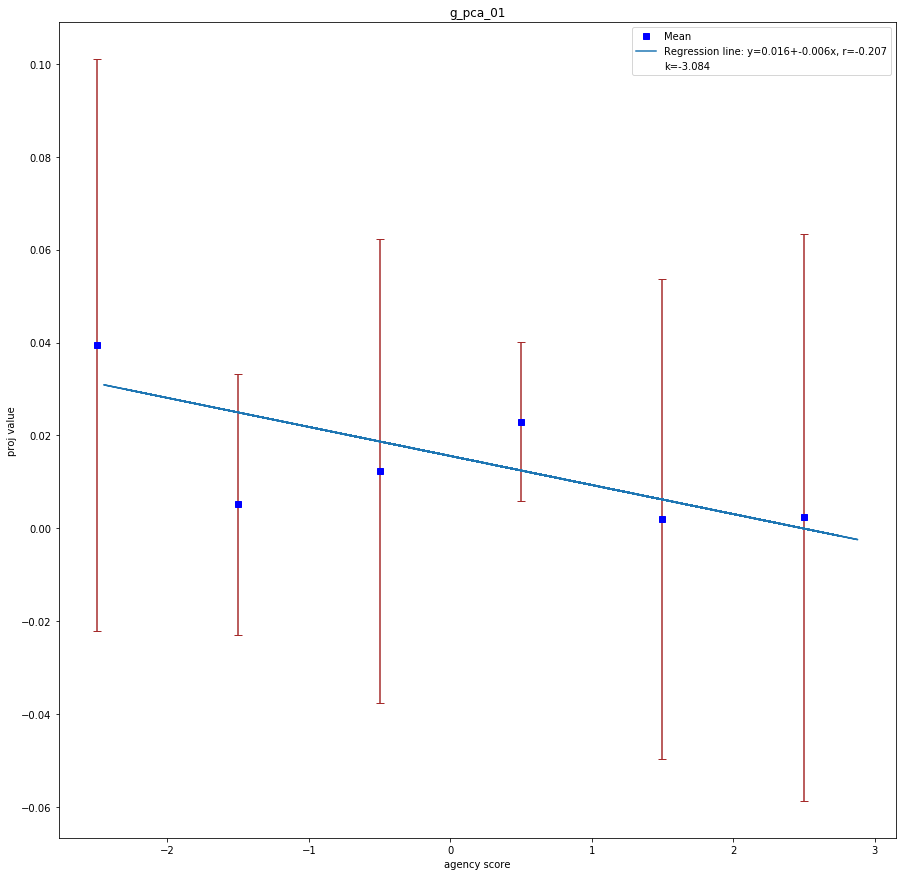

In [132]:
# agency plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col3)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), ag_avg_proj_g_pca_01, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(ag_ext_g_pca_01)):
    if ag_ext_g_pca_01[i] < 0:
        print("warning: negative extension value")
    ymins.append(ag_avg_proj_g_pca_01[i]-ag_ext_g_pca_01[i]/2)
    ymaxs.append(ag_avg_proj_g_pca_01[i]+ag_ext_g_pca_01[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)

score_max = np.max(ag_com_mean_col5)
score_min = np.min(ag_com_mean_col5)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
k_ag_g_pca_01 = avg_diff_g_pca_01/line_delta
plt.plot([], [], ' ', label=f'k={k_ag_g_pca_01:1.3f}')

ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/ag/g_g_pca_01')

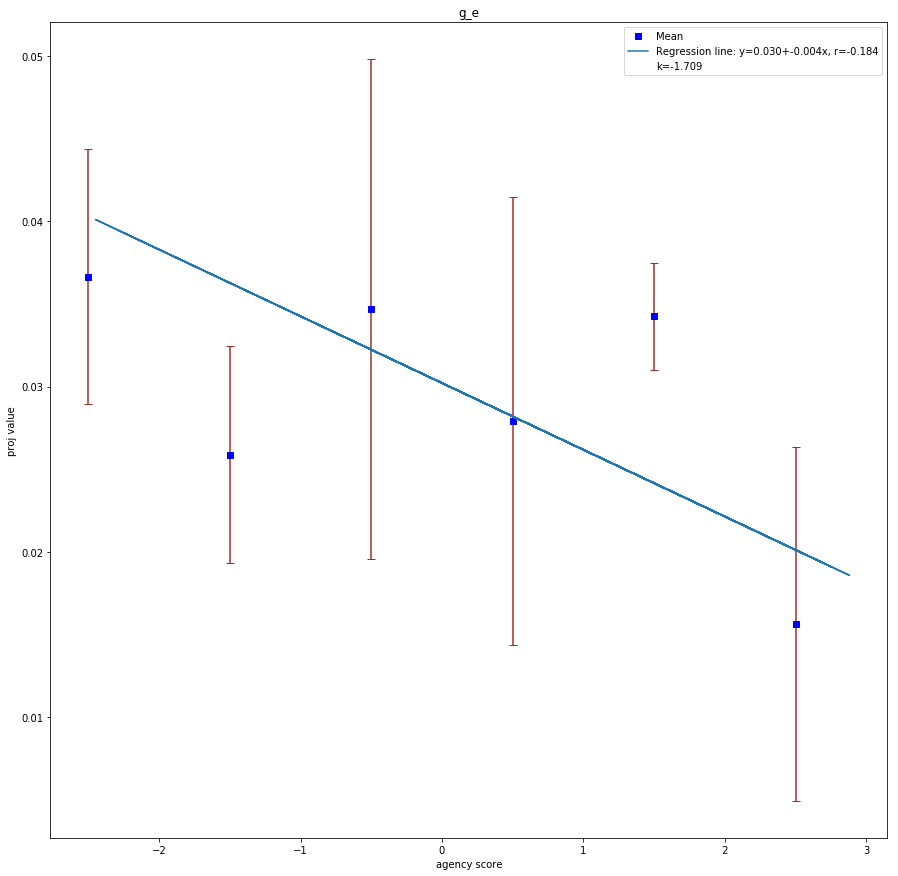

In [133]:
# agency plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col5, ag_com_mean_col4)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), ag_avg_proj_g_e, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(ag_ext_g_e)):
    if ag_ext_g_e[i] < 0:
        print("warning: negative extension value")
    ymins.append(ag_avg_proj_g_e[i]-ag_ext_g_e[i]/2)
    ymaxs.append(ag_avg_proj_g_e[i]+ag_ext_g_e[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col5), intercept + slope * np.array(ag_com_mean_col5), label=line)

score_max = np.max(ag_com_mean_col5)
score_min = np.min(ag_com_mean_col5)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
k_ag_g_e = avg_diff_g_e/line_delta
plt.plot([], [], ' ', label=f'k={k_ag_g_e:1.3f}')

ax.set_xlabel('agency score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/ag/g_g_e')

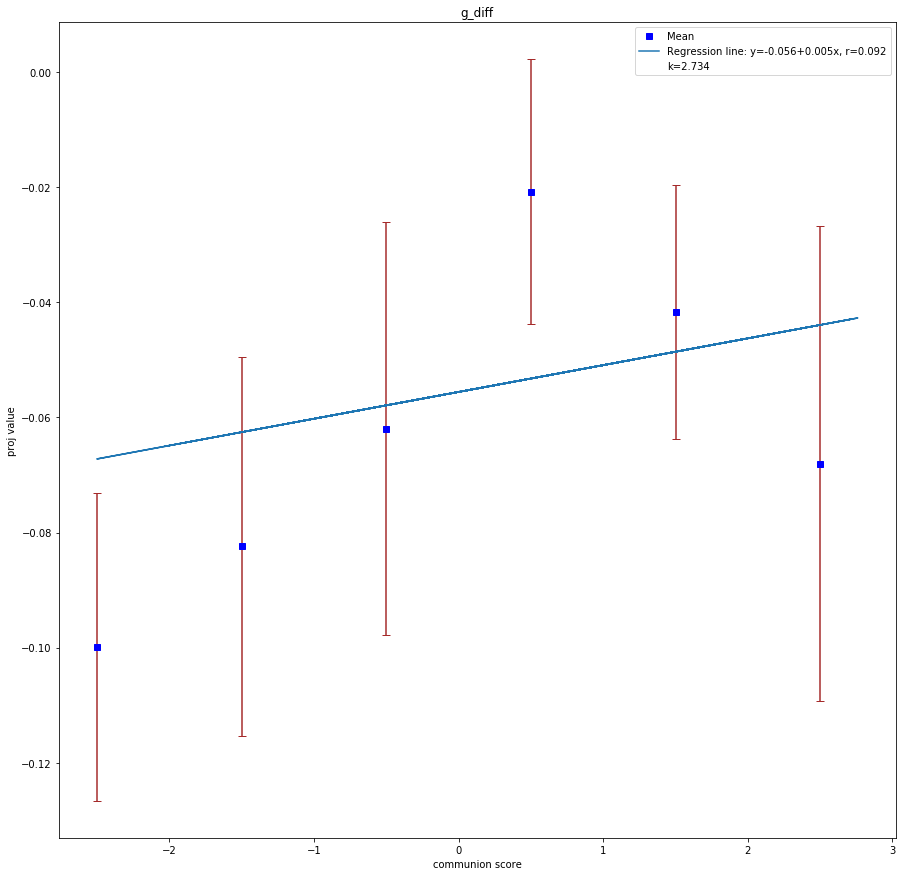

In [134]:
# communion plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col1)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), com_avg_proj_g_diff, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(com_ext_g_diff)):
    if com_ext_g_diff[i] < 0:
        print("warning: negative extension value")
    ymins.append(com_avg_proj_g_diff[i]-com_ext_g_diff[i]/2)
    ymaxs.append(com_avg_proj_g_diff[i]+com_ext_g_diff[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)

score_max = np.max(ag_com_mean_col6)
score_min = np.min(ag_com_mean_col6)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
k_com_g_diff = avg_diff_g_diff/line_delta
plt.plot([], [], ' ', label=f'k={k_com_g_diff:1.3f}')

ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/com/g_g_diff')

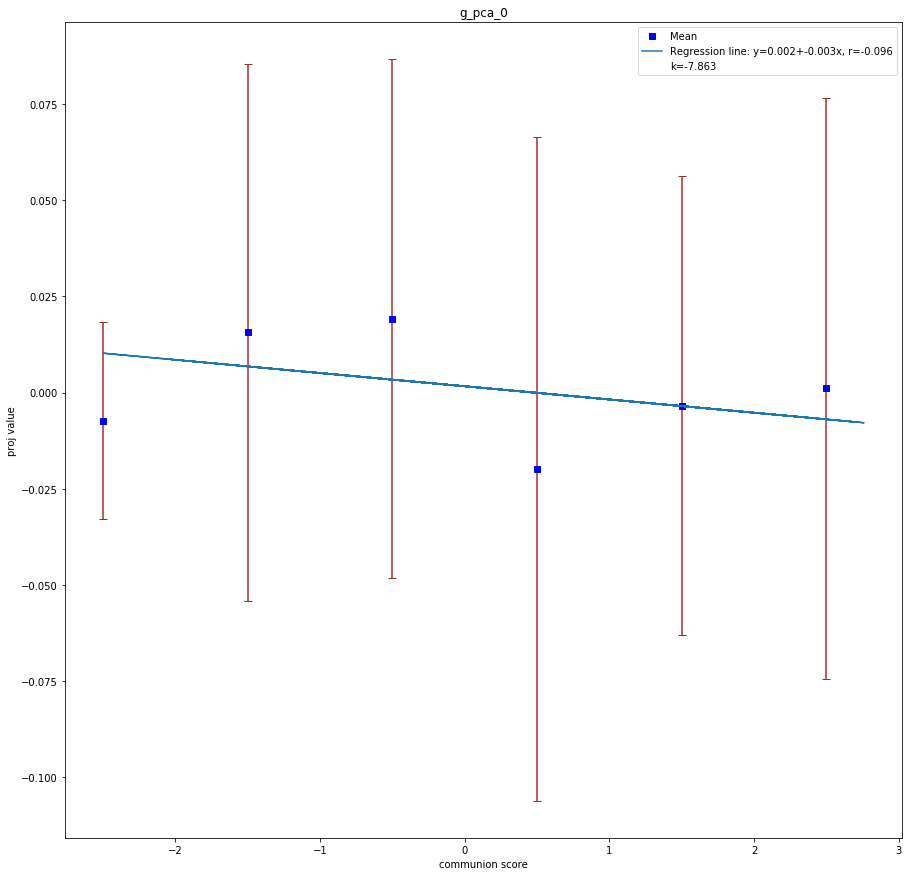

In [135]:
# communion plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col2)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), com_avg_proj_g_pca_0, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(com_ext_g_pca_0)):
    if com_ext_g_pca_0[i] < 0:
        print("warning: negative extension value")
    ymins.append(com_avg_proj_g_pca_0[i]-com_ext_g_pca_0[i]/2)
    ymaxs.append(com_avg_proj_g_pca_0[i]+com_ext_g_pca_0[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)

score_max = np.max(ag_com_mean_col6)
score_min = np.min(ag_com_mean_col6)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
k_com_g_pca_0 = avg_diff_g_pca_0/line_delta
plt.plot([], [], ' ', label=f'k={k_com_g_pca_0:1.3f}')

ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/com/g_g_pca_0')

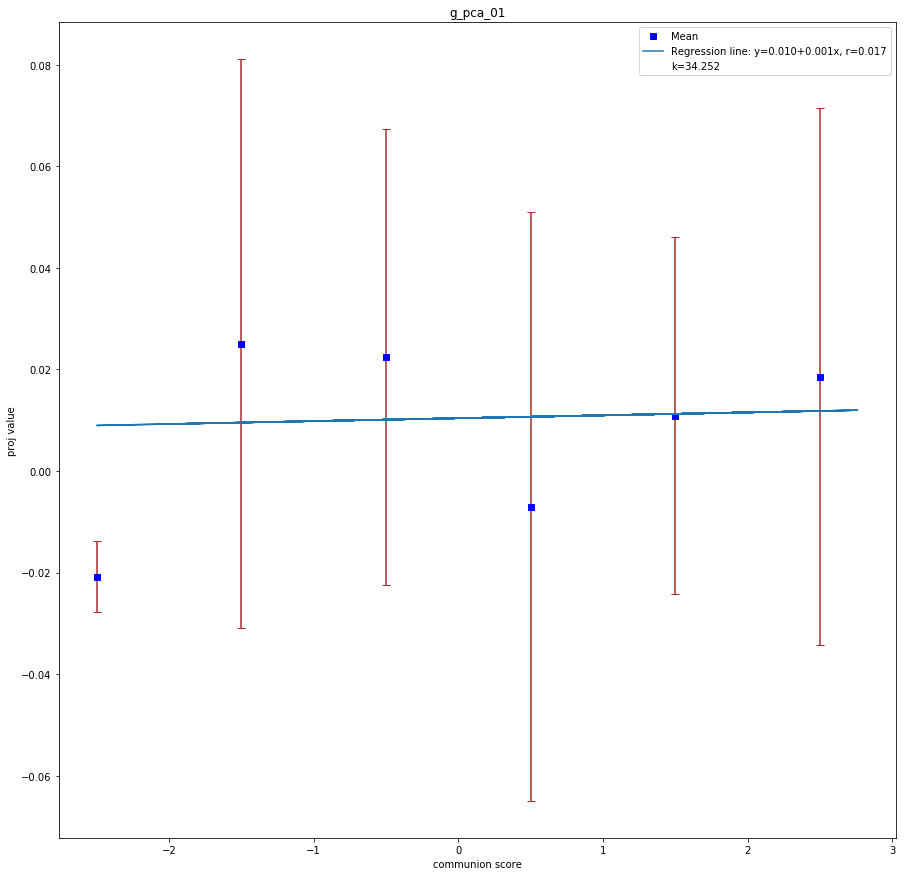

In [136]:
# communion plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col3)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), com_avg_proj_g_pca_01, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(com_ext_g_pca_01)):
    if com_ext_g_pca_01[i] < 0:
        print("warning: negative extension value")
    ymins.append(com_avg_proj_g_pca_01[i]-com_ext_g_pca_01[i]/2)
    ymaxs.append(com_avg_proj_g_pca_01[i]+com_ext_g_pca_01[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)

score_max = np.max(ag_com_mean_col6)
score_min = np.min(ag_com_mean_col6)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
k_com_g_pca_01 = avg_diff_g_pca_01/line_delta
plt.plot([], [], ' ', label=f'k={k_com_g_pca_01:1.3f}')

ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/com/g_g_pca_01')

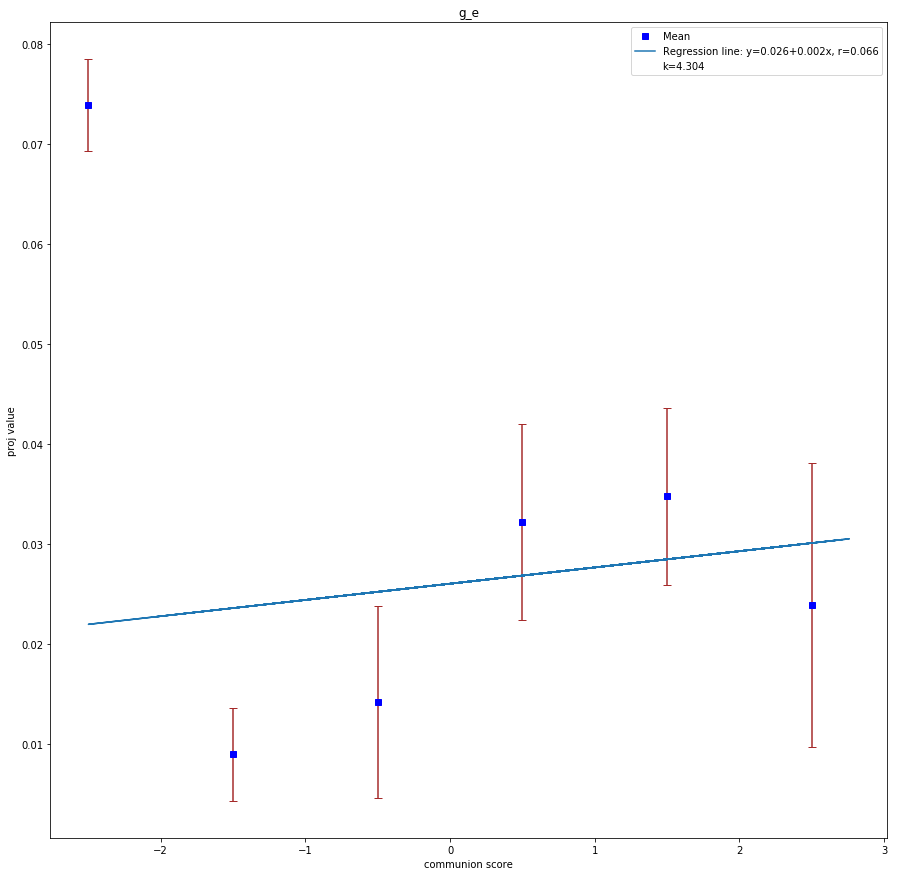

In [137]:
# communion plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ag_com_mean_col6, ag_com_mean_col4)
line = f'Regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.3f}'

fig = plt.figure(figsize=(15,15))    
ax = fig.add_subplot(111)
ax.plot(np.arange(-2.5,3,1), com_avg_proj_g_e, linewidth=0, marker='s', color='blue', label='Mean')

ymins = []
ymaxs = []
for i in range(len(com_ext_g_e)):
    if com_ext_g_e[i] < 0:
        print("warning: negative extension value")
    ymins.append(com_avg_proj_g_e[i]-com_ext_g_e[i]/2)
    ymaxs.append(com_avg_proj_g_e[i]+com_ext_g_e[i]/2)  

plt.vlines(np.arange(-2.5,3,1), ymin=ymins, ymax=ymaxs, color='brown')
ax.plot(np.arange(-2.5,3,1), ymaxs, linewidth=0, marker='_', markersize=8, color='brown')
ax.plot(np.arange(-2.5,3,1), ymins, linewidth=0, marker='_', markersize=8, color='brown')

ax.plot(np.array(ag_com_mean_col6), intercept + slope * np.array(ag_com_mean_col6), label=line)

score_max = np.max(ag_com_mean_col6)
score_min = np.min(ag_com_mean_col6)
line_max = intercept + slope*score_max
line_min = intercept + slope*score_min
line_delta = line_max - line_min
k_com_g_e = avg_diff_g_e/line_delta
plt.plot([], [], ' ', label=f'k={k_com_g_e:1.3f}')

ax.set_xlabel('communion score')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

plt.show()
fig.savefig('k-plot/com/g_g_e')

In [138]:
# print k
print('k_ag_g_diff:    %6.3lf' % (k_ag_g_diff))
print('k_ag_g_pca_0:   %6.3f' % (k_ag_g_pca_0))
print('k_ag_g_pca_01:  %6.3f' % (k_ag_g_pca_01))
print('k_ag_g_e:       %6.3f' % (k_ag_g_e))
print()
print('k_com_g_diff:   %6.3f' % (k_com_g_diff))
print('k_com_g_pca_0:  %6.3f' % (k_com_g_pca_0))
print('k_com_g_pca_01: %6.3f' % (k_com_g_pca_01))
print('k_com_g_e:      %6.3f' % (k_com_g_e))

k_ag_g_diff:     0.843
k_ag_g_pca_0:   -4.475
k_ag_g_pca_01:  -3.084
k_ag_g_e:       -1.709

k_com_g_diff:    2.734
k_com_g_pca_0:  -7.863
k_com_g_pca_01: 34.252
k_com_g_e:       4.304
